<img align="right" src="https://www.tedu.edu.tr/themes/custom/tedu/logo.svg" width="350px" height="350px"/>
<h1 style="font-size:20pt">ADS 542- Statistical Learning| Final/Project </h1><br/>
<b> Author: </b> Cem Koçak <br/>
<b> Created: </b>20 May 2023<br/>

**The table of Contents include anchor tags to allow easy navigation**

<font size="5"> **Project Details:**

## Table of Contents
* [1. Data Cleaning](#1)
    * [1.1 Detecting Quality Issues](#1.1)
    * [1.2 EDA ](#1.2)
    * [1.3 Imputation Of Missing Values ](#1.3)
    * [1.4 Handling Outliers](#1.4)
    * [1.5 EDA After Cleaning](#1.5)
* [2. Data Preprocessing](#2)
* [3. Feature Engineering (Contains Feature Selection)](#3)
* [4. Model Selection](#4)
    * [4.1 Ridge Regression](#4.1)
    * [4.2 Logistic Regression](#4.2)
    * [4.3 Random Forest Classifier (Optimal Model Is Here)](#4.3)
    * [4.4 Decision Tree (Used On Streamlit App) ](#4.4)
    * [4.5 Gradient Boosting Classifier](#4.5)
    * [4.6 XGBoost](#4.6)
    * [4.7 Imputation To Satisfy Project Requirements](#4.7)
* [5. Conclusion](#5)

In [1]:
from IPython.display import IFrame
IFrame("./FinalProjectMs.pdf", width=900, height=600)

**Below is screenshot of parameter description found in readme file of the dataset**

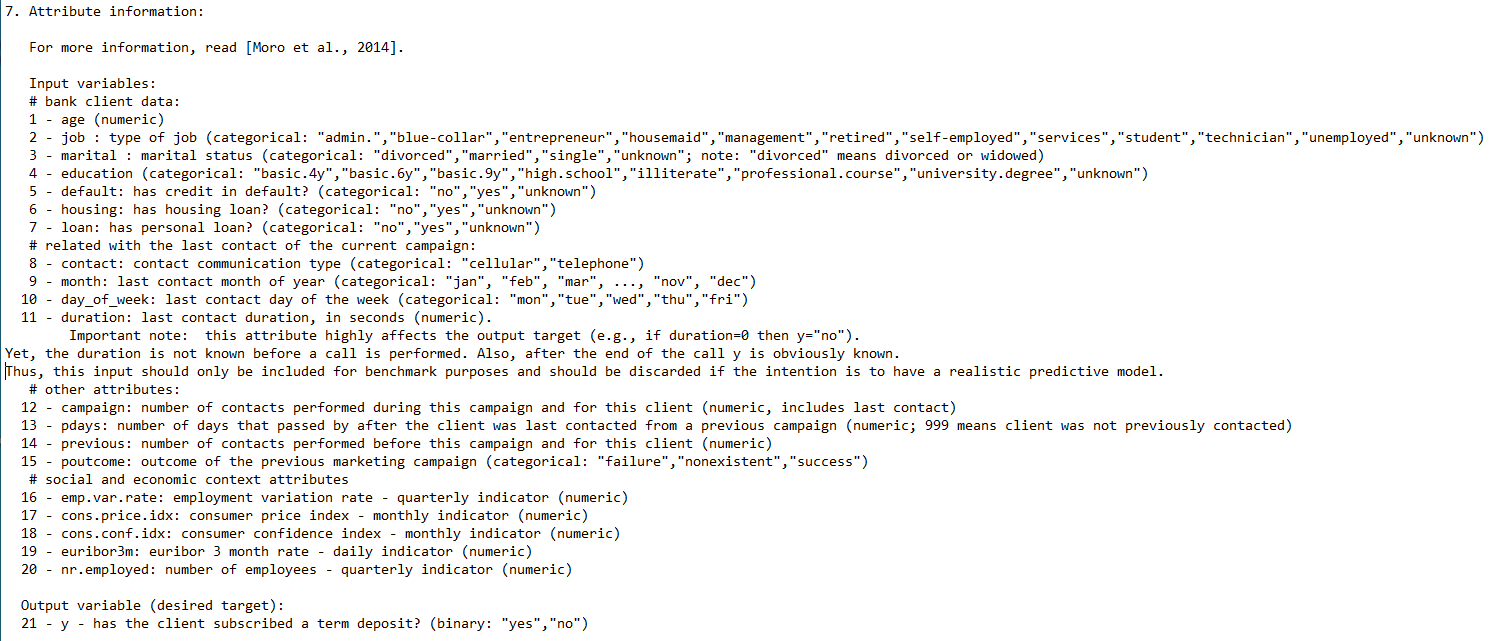

In this project from domain knowledge and as it was mentioned by our instructor during a class, most important outcome to capture is to correctly predict the people who will response yes. So the most important methric is the sensitivity/recall of the class yes. 

However its also important to reduce false positives as much as possible as a secondary objective.

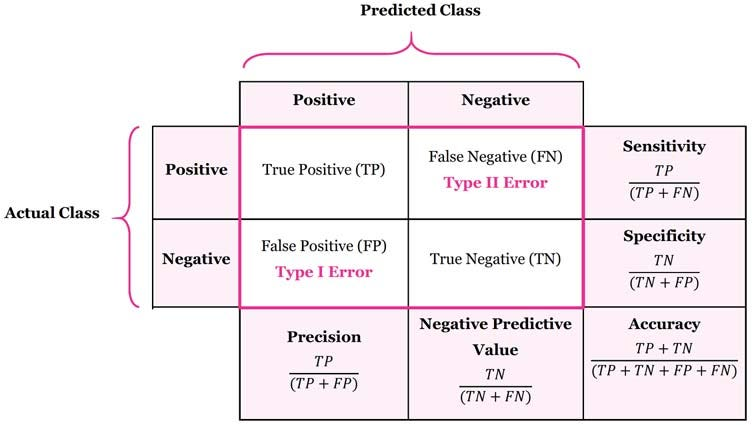

Another great way to set goal is to maximize TPR and TNR values. For this bussiness problem TPR should have a higher priority. As an easier way roc auc score can be used to obtain a smilar optimal model. <br>
If time permitting I will use a non-anaconda platform to use tensorflow_model_analysis package for making such computations. Else I will rely on other methods.

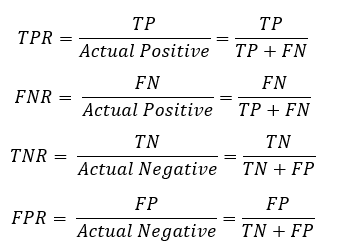

<font size="5"> **Importing Libraries Initilizing Settings And Loading Data**

In [2]:
import random

import pandas as pd
import numpy as np

import missingno as msno

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso,RidgeClassifier,LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,mean_squared_error,classification_report,roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import f1_score, recall_score,roc_auc_score

from patsy import dmatrices, dmatrix

from IPython.display import Audio

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier

#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OrdinalEncoder
#from sklearn.impute import KNNImputer

After asking for permission I decided to use full dataset instead of the %10 version asked in project details pdf.

In [3]:
data = pd.read_csv("bank-additional-full.csv",sep=";")

In [4]:
df = data.copy()

In [5]:
pd.set_option('display.max_columns',None) #Always display all columns instead of ... in the middle

In [6]:
random.seed(0)

In [7]:
sound_file = "stop.mp3"

In [8]:
Audio(sound_file, autoplay=True)

## 1. Data Cleaning <a class="anchor" id="1"></a>

### 1.1 Detecting Quality Issues <a class="anchor" id="1.1"></a>

In [9]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [10]:
print(df.describe())
print("/n /n")
print(df.info())

               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

In [11]:
df.isnull().sum() # Counting missing values for each column

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
df.duplicated().sum() #counting the number of duplicate rows

12

In [13]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


Rows with duplicate values in succession are almost certainly duplicate entries. Others could be duplicates but could also be customers who just happen to share many attributes. Considering there is 41188 entries this outcome is not unlikely nor coincidental in reasonable amounts. From above I can see the amount is reasonable and also pdays would be extremely likely to differ(but impossible for both entries to be 999 as it stands for never contacted) if they were caused by contacting the same customer multiple times.

I have also decided to count close valued indexes adjecent enough.
Rows chosen to be removed: 1266 12261 18465 20534 28477 32516 36951
After this there will be 5 duplicate rows which I deemed to be valid as they are likelier to exist from same attribute entries rather than a twice recorded single entry.

In [14]:
df.drop(index=[1266,12261,18465,20534,28477,32516,36951],inplace=True)

In [15]:
#to investigate if there are multiple datatypes in a column
#to check if there are some values in columns that are of the wrong type

for col in df.columns:
    print(df[col].apply(type).value_counts())
    print("")

<class 'int'>    41181
Name: age, dtype: int64

<class 'str'>    41181
Name: job, dtype: int64

<class 'str'>    41181
Name: marital, dtype: int64

<class 'str'>    41181
Name: education, dtype: int64

<class 'str'>    41181
Name: default, dtype: int64

<class 'str'>    41181
Name: housing, dtype: int64

<class 'str'>    41181
Name: loan, dtype: int64

<class 'str'>    41181
Name: contact, dtype: int64

<class 'str'>    41181
Name: month, dtype: int64

<class 'str'>    41181
Name: day_of_week, dtype: int64

<class 'int'>    41181
Name: duration, dtype: int64

<class 'int'>    41181
Name: campaign, dtype: int64

<class 'int'>    41181
Name: pdays, dtype: int64

<class 'int'>    41181
Name: previous, dtype: int64

<class 'str'>    41181
Name: poutcome, dtype: int64

<class 'float'>    41181
Name: emp.var.rate, dtype: int64

<class 'float'>    41181
Name: cons.price.idx, dtype: int64

<class 'float'>    41181
Name: cons.conf.idx, dtype: int64

<class 'float'>    41181
Name: euribor3m, dty

No infeasible values to indicate representation of missing value such as negative value for age.

There seems to be some missing values represented as unknown values. Removal or replacement has to be done.

In [16]:
for col in df.columns:
    if np.dtype(df[col])=="int64" or np.dtype(df[col])=="float64":
        print(col)
        print(df[col].value_counts())
        print(df[col].nunique())
        print("")

age
31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64
78

duration
90      170
85      170
136     168
73      167
124     163
       ... 
1569      1
1053      1
1263      1
1169      1
1868      1
Name: duration, Length: 1544, dtype: int64
1544

campaign
1     17636
2     10570
3      5341
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: campaign, dtype: int64
42

pdays
999    39666
3        439
6        412
4        118
9         64
2         61
7         60
12

Object as a Dtype is a concern for data quality because it prevents necessary operations such as string operations on categorical variables. So they could be converted to category type.

In [17]:
for col in df.columns:
    if df[col].dtype==object:
        df[col]=df[col].astype("category")

### 1.2 EDA <a class="anchor" id="1.2"></a>

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>],
       [<Axes: title={'center': 'cons.price.idx'}>,
        <Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr.employed'}>, <Axes: >, <Axes: >]],
      dtype=object)

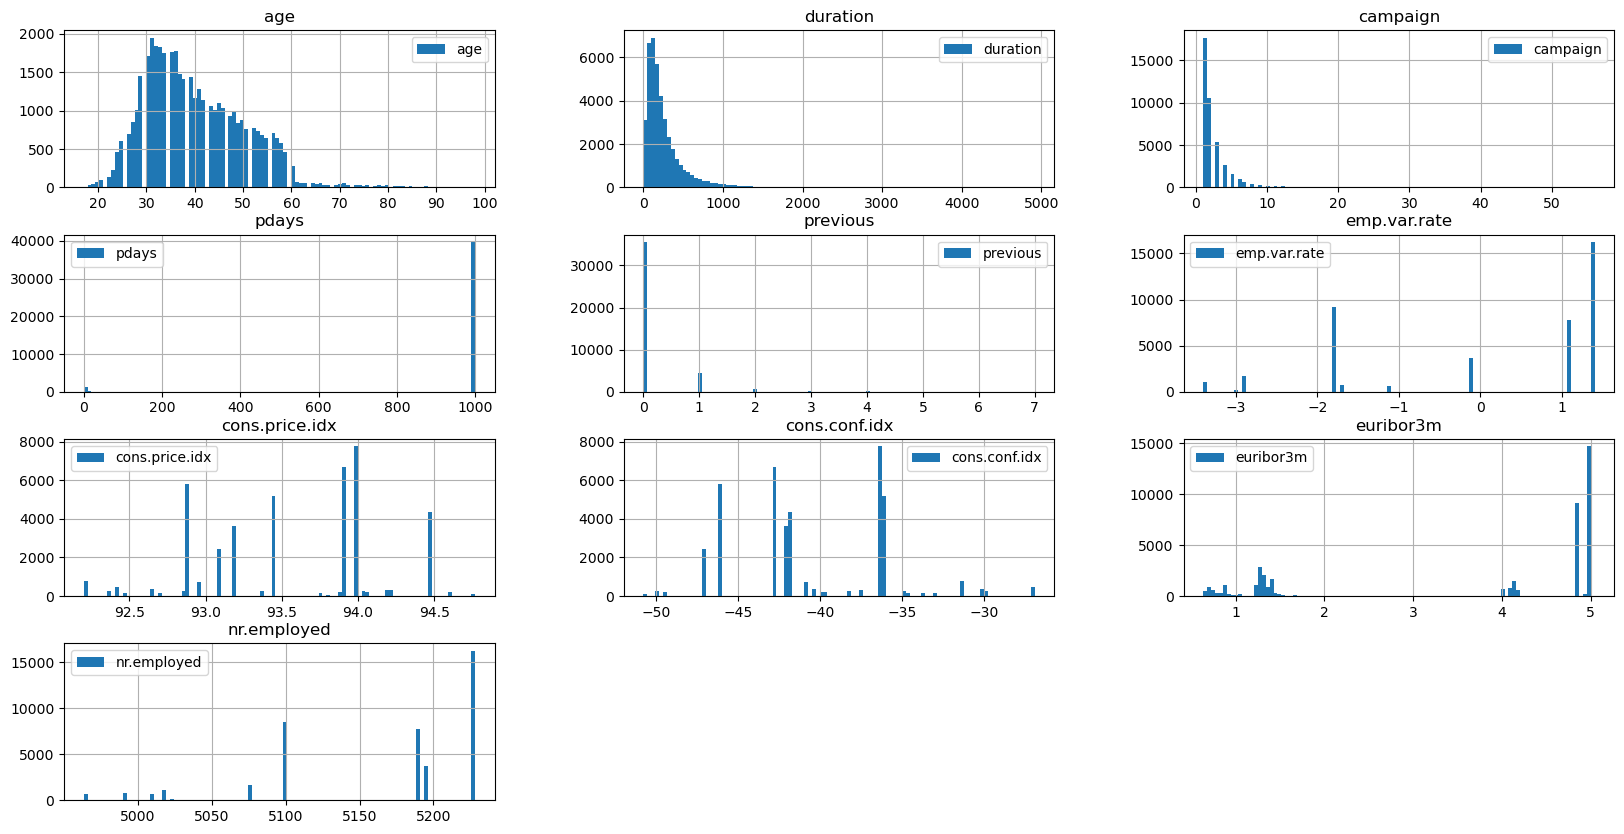

In [18]:
df.hist(figsize=(20,10),legend=True,bins=100)

None of the data are normally(near normally) distributed.

<Figure size 3000x600 with 0 Axes>

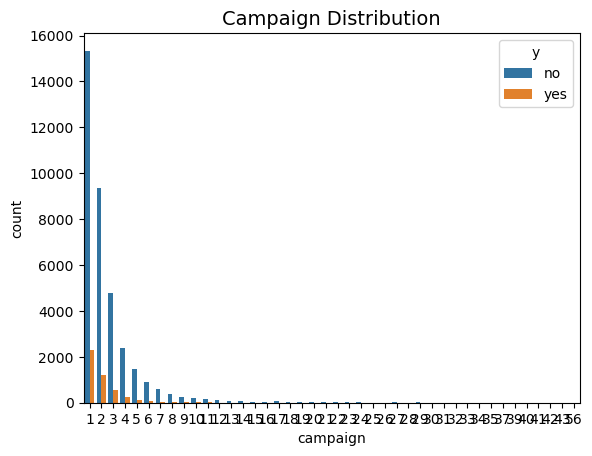

<Figure size 3000x600 with 0 Axes>

In [19]:
sns.countplot(data=df,x="campaign",hue="y")
plt.title("Campaign Distribution", fontsize=14)
plt.figure(figsize=(30,6))

Text(0.5, 1.0, 'Previous Distribution')

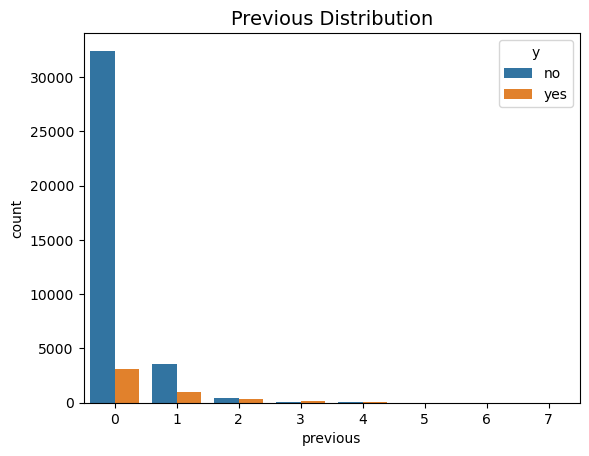

In [20]:
sns.countplot(data=df,x="previous",hue="y")
plt.title("Previous Distribution", fontsize=14)

Text(0.5, 1.0, 'Target Distribution')

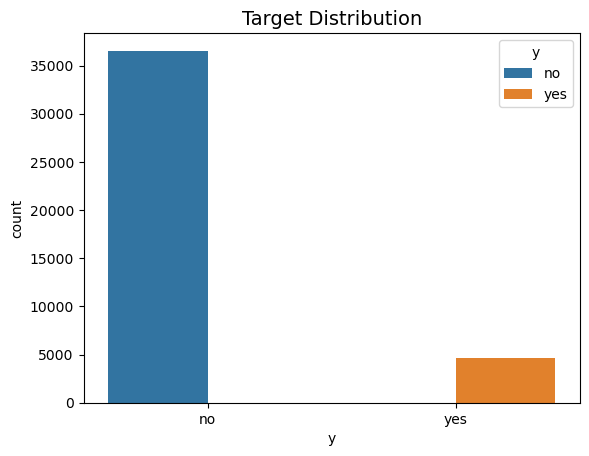

In [21]:
sns.countplot(data=df,x="y",hue="y")
plt.title("Target Distribution", fontsize=14)

In [22]:
dfgrouped = df.groupby('y')

In [23]:
def feature_perc(feature,groupby= 'yes'):

    count = dfgrouped.get_group(groupby)[feature].value_counts()
    total_count = df[feature].value_counts()[count.index]
    perc = (count/total_count)*100
    return perc 

In [24]:
def plot_barh(array,incrementer, bias):
    
    plt.barh(array.index, width = array.values, height = .5)
    plt.yticks(np.arange(len(array)))

    for index, value in enumerate(array.values):
        plt.text(value+.5 , index, s= '{:.1f}%'.format(value))

    return plt

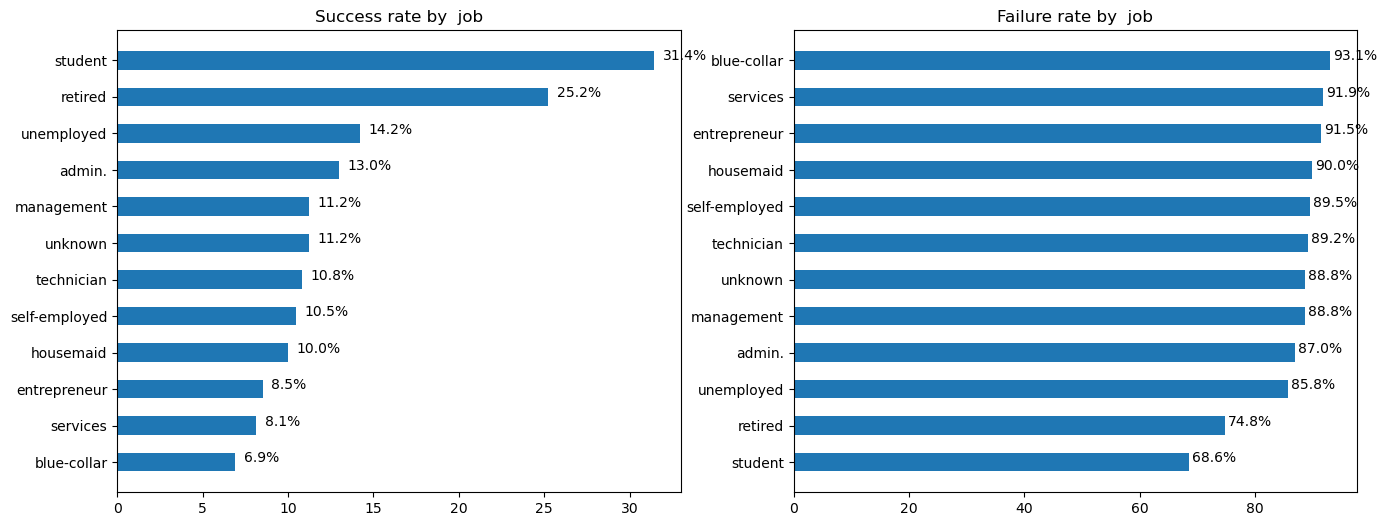

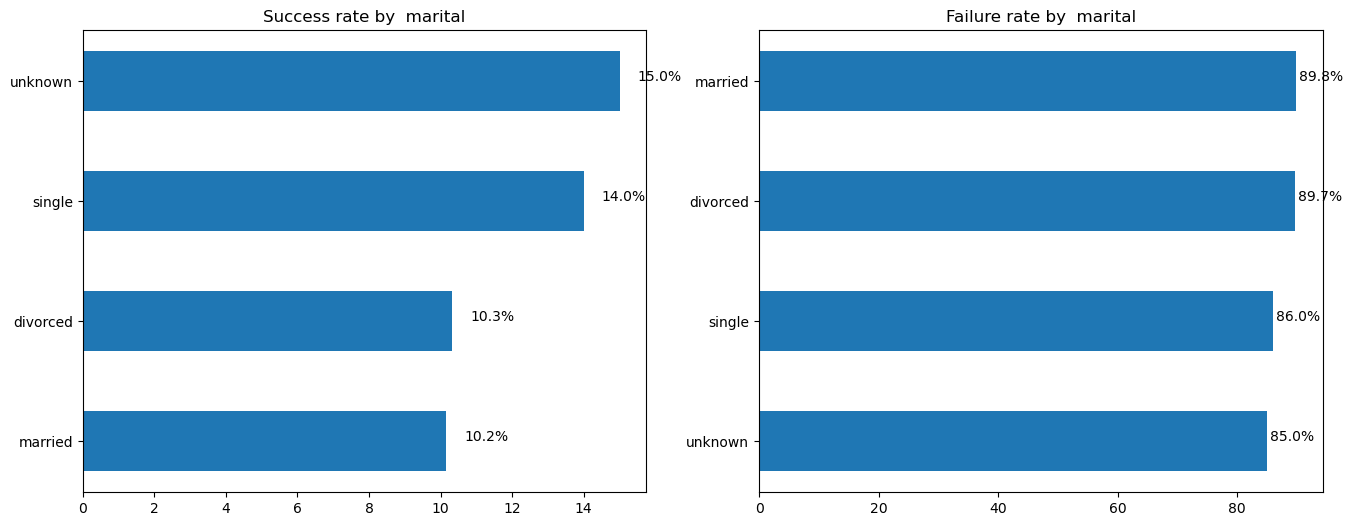

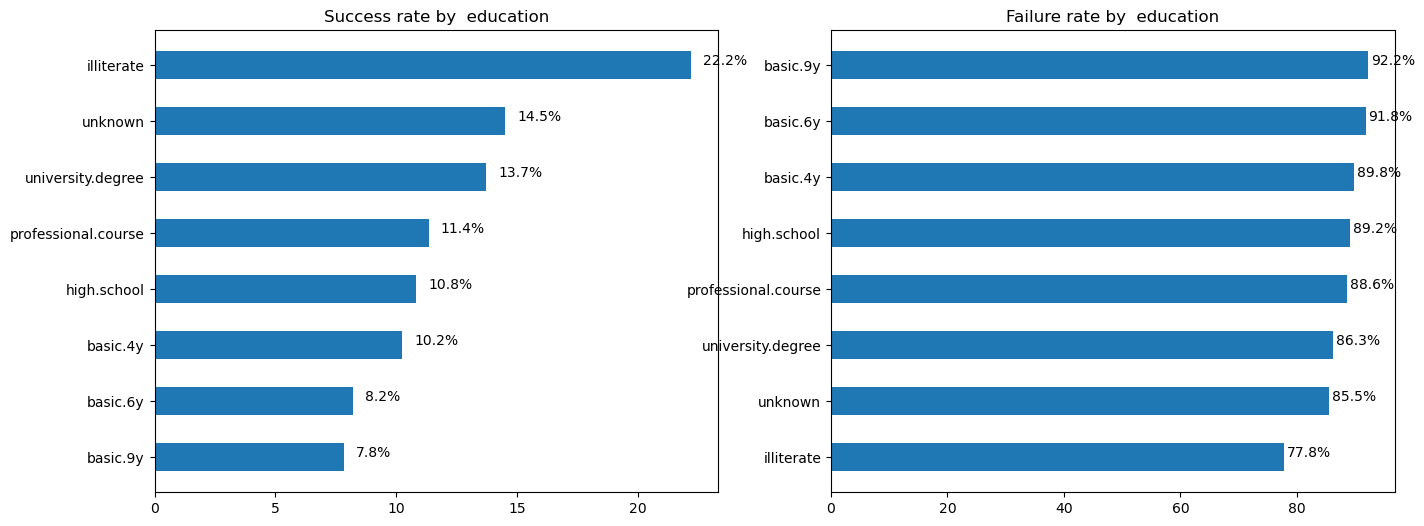

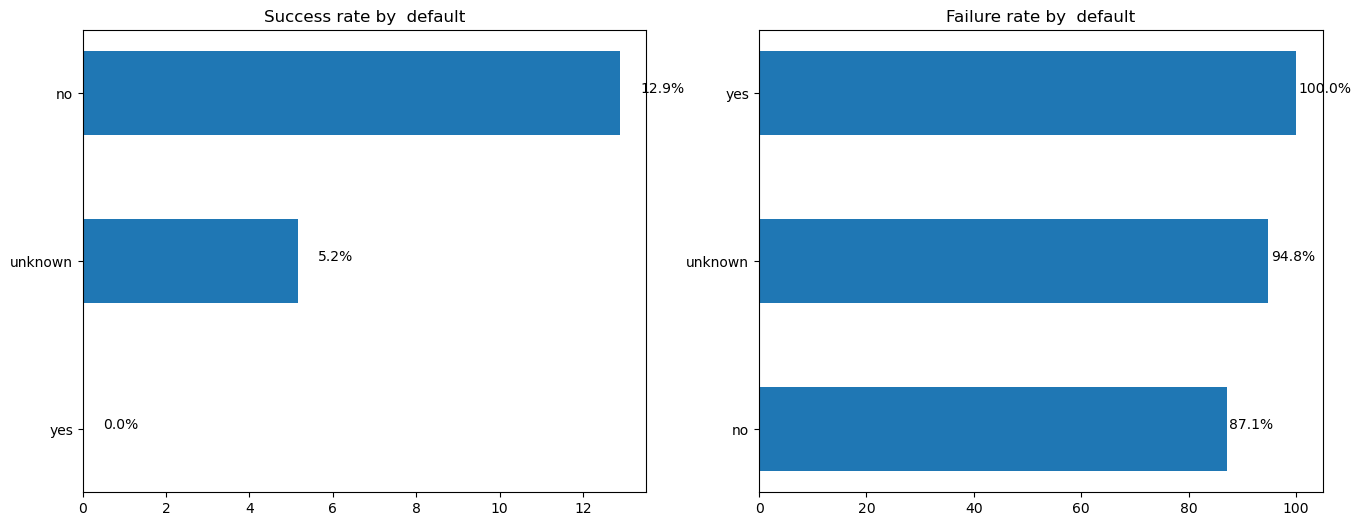

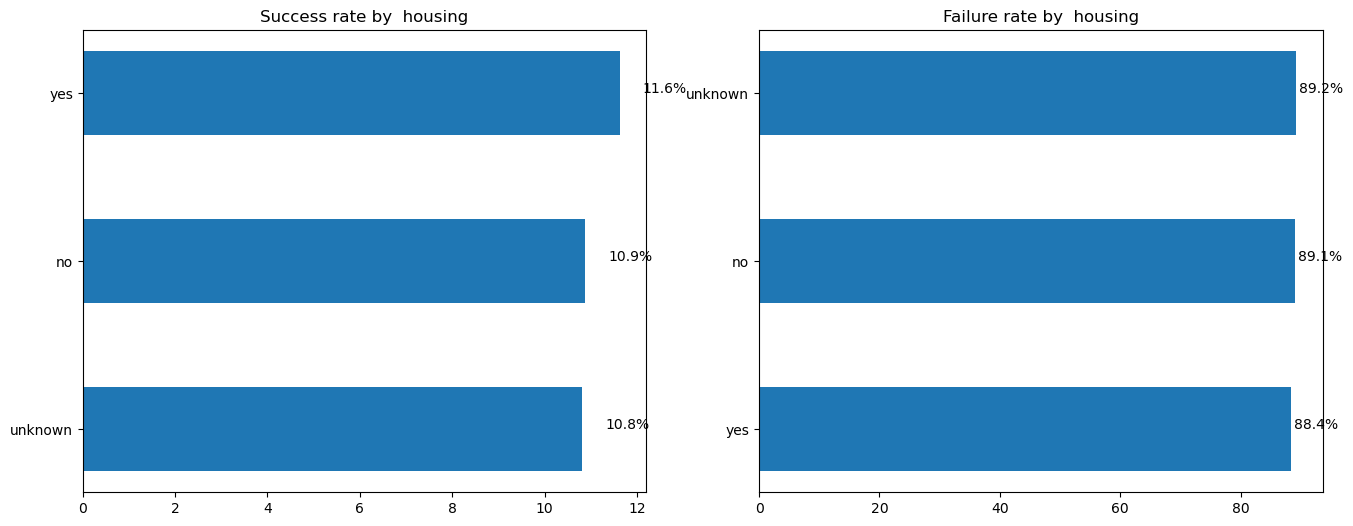

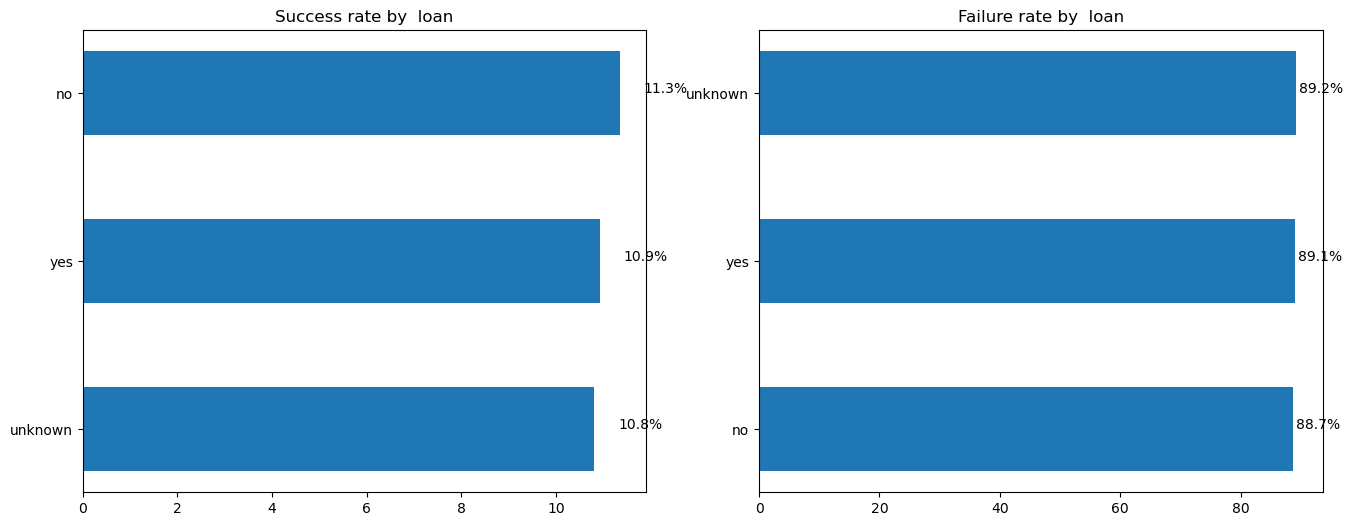

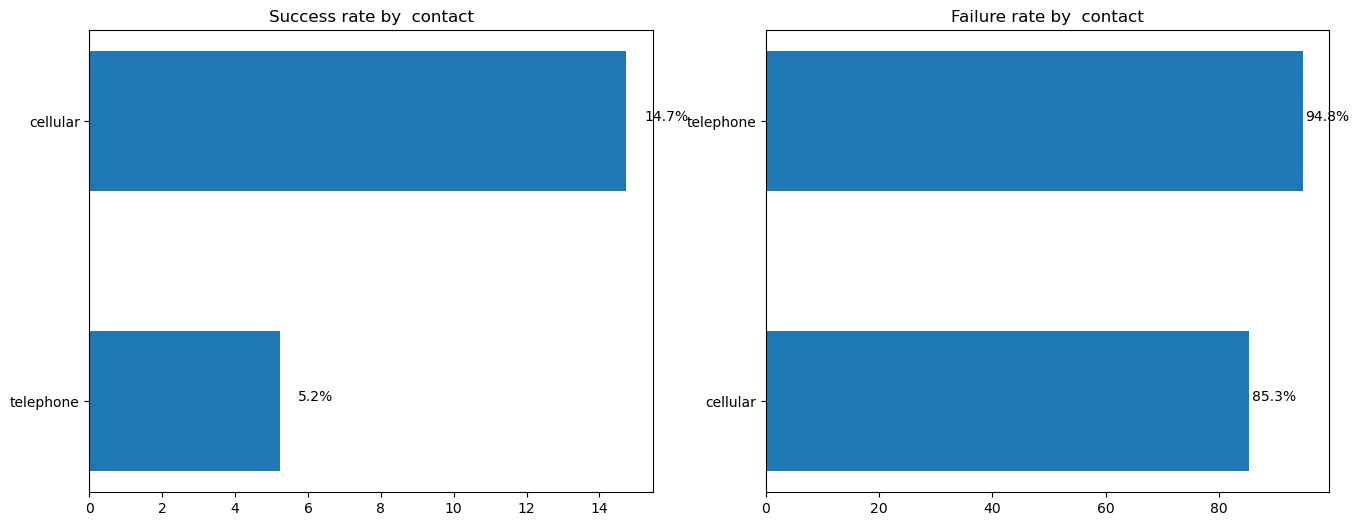

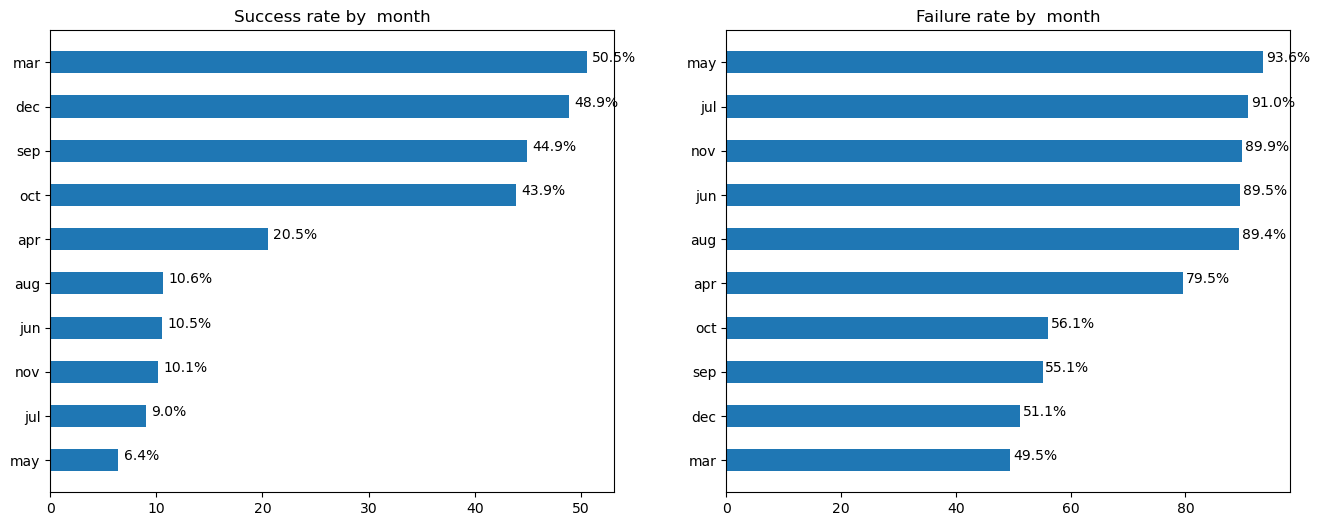

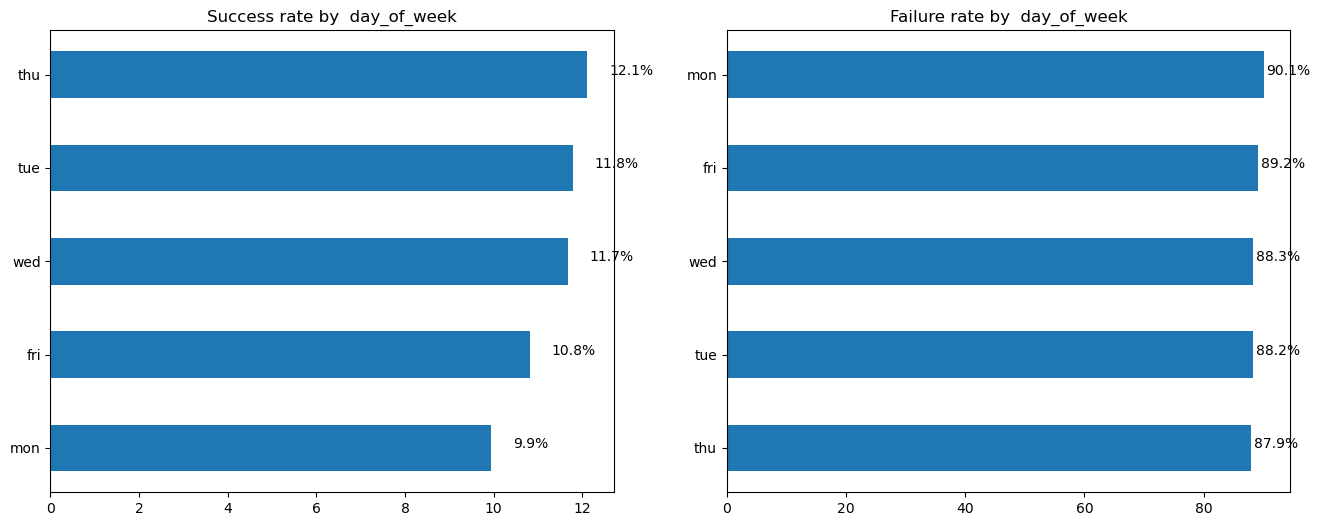

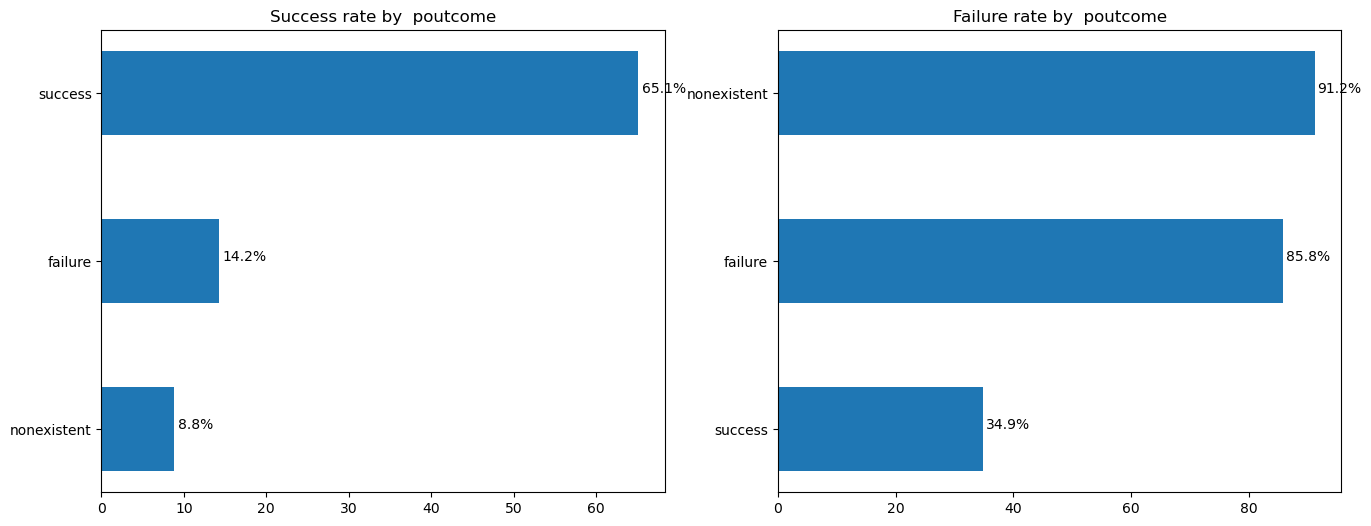

In [25]:
cat_cols = df.dtypes[df.dtypes == "category"].index
for column in cat_cols[:-1]: #Slicing to exclude y

    yes_perc = feature_perc(column, groupby="yes")
    no_perc = feature_perc(column, groupby="no")

    plt.figure(figsize=(16,6))

    plt.subplot(1,2,1)
    plt.title(f'Success rate by  {column}')
    plot_barh(yes_perc.sort_values(),5,10)

    plt.subplot(1,2,2)
    plt.title(f'Failure rate by  {column}')
    plot_barh(no_perc.sort_values(),5,10)
    plt.show()
    print()

### 1.3 Imputation Of Missing Values <a class="anchor" id="1.3"></a>

Some of the entries had unknown as values. This implies those components were missing.

In [26]:
print("Columns with unknown value: \n")
columns_with_missing=[]
for col in df.columns:
    if df[col].dtype=="category":
        if df[df[col]=="unknown"].shape[0] > 0:
            columns_with_missing.append(col)
            print(col)

Columns with unknown value: 

job
marital
education
default
housing
loan


In [27]:
for col in columns_with_missing:
    df[col].replace(to_replace="unknown",value=np.nan,inplace=True)

<Axes: >

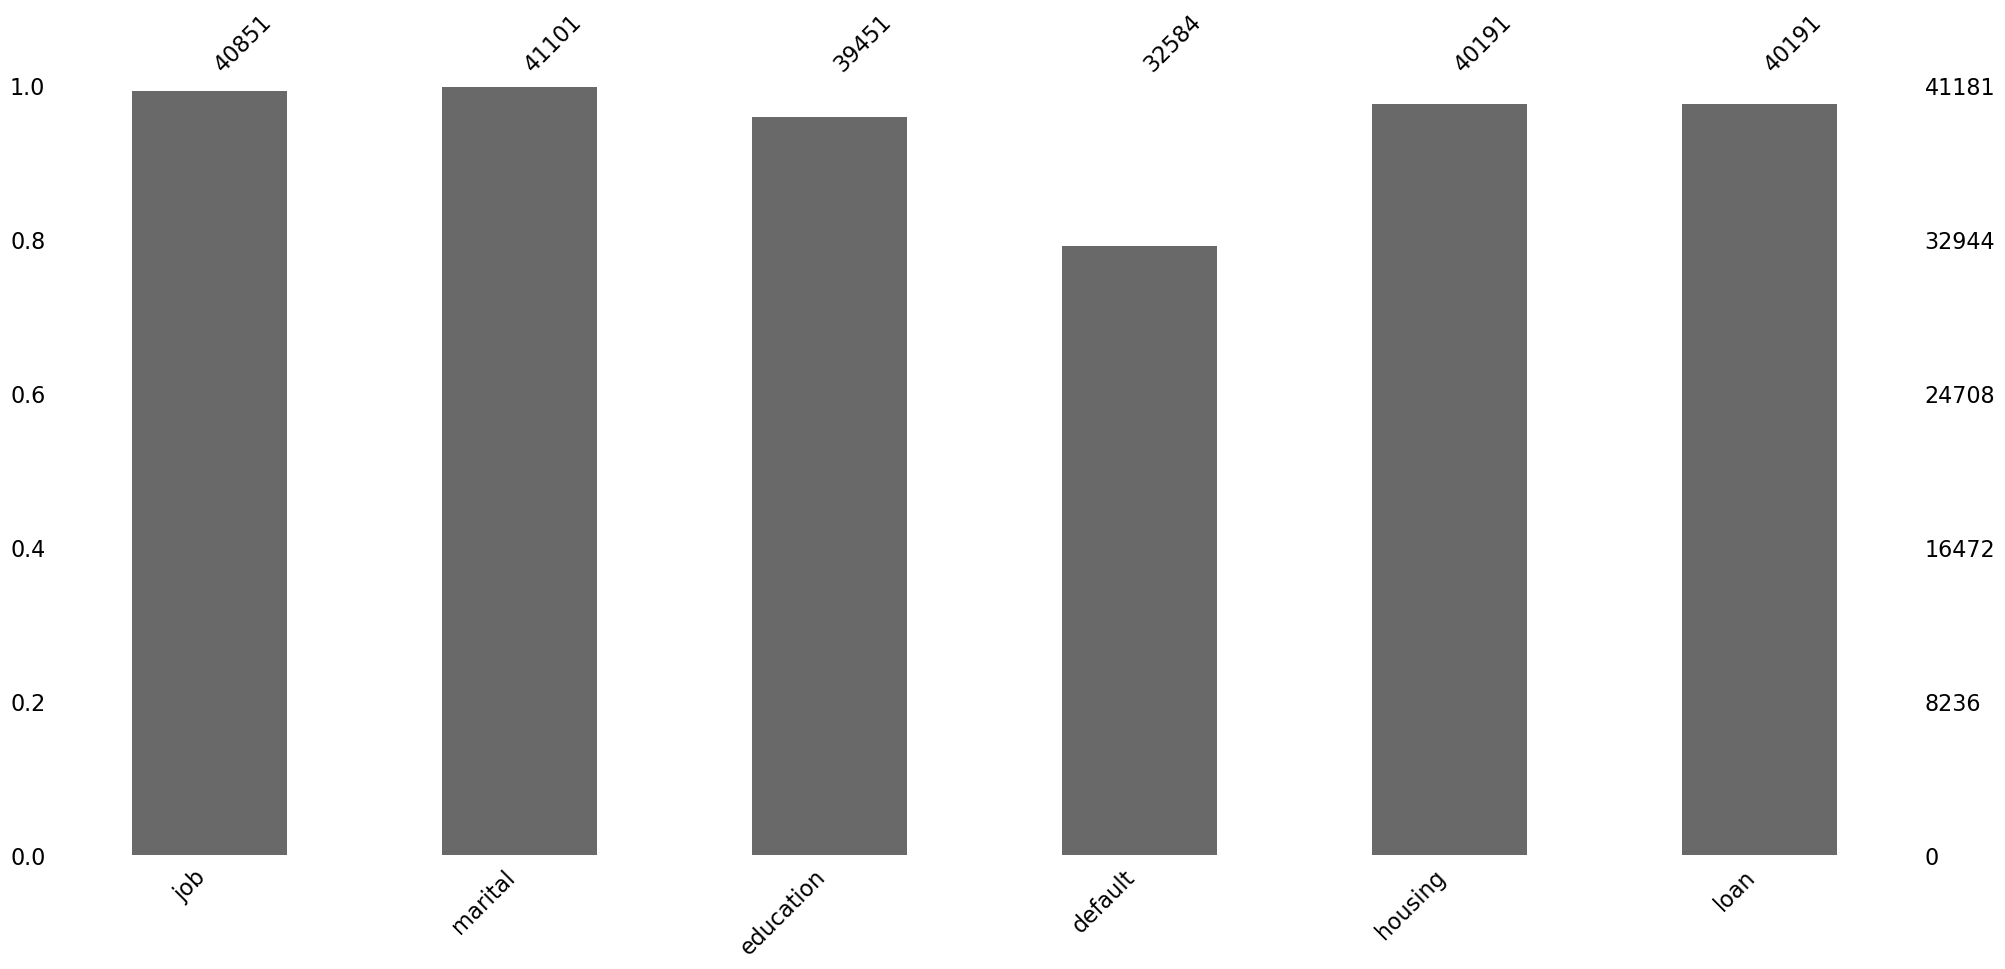

In [28]:
msno.bar(df[columns_with_missing])

**Upon Researching I found that the current version of missingno avaliable on anaconda is not up to date with matplotlibs changing of parameter b to visible in an update. Also I have checked and found anaconda hasnt issued a newer version of missingno for years so I decided to use the below code in markdown on googlecolab and insert the output as image manually**

msno.matrix(df) <br>
above code outputs:

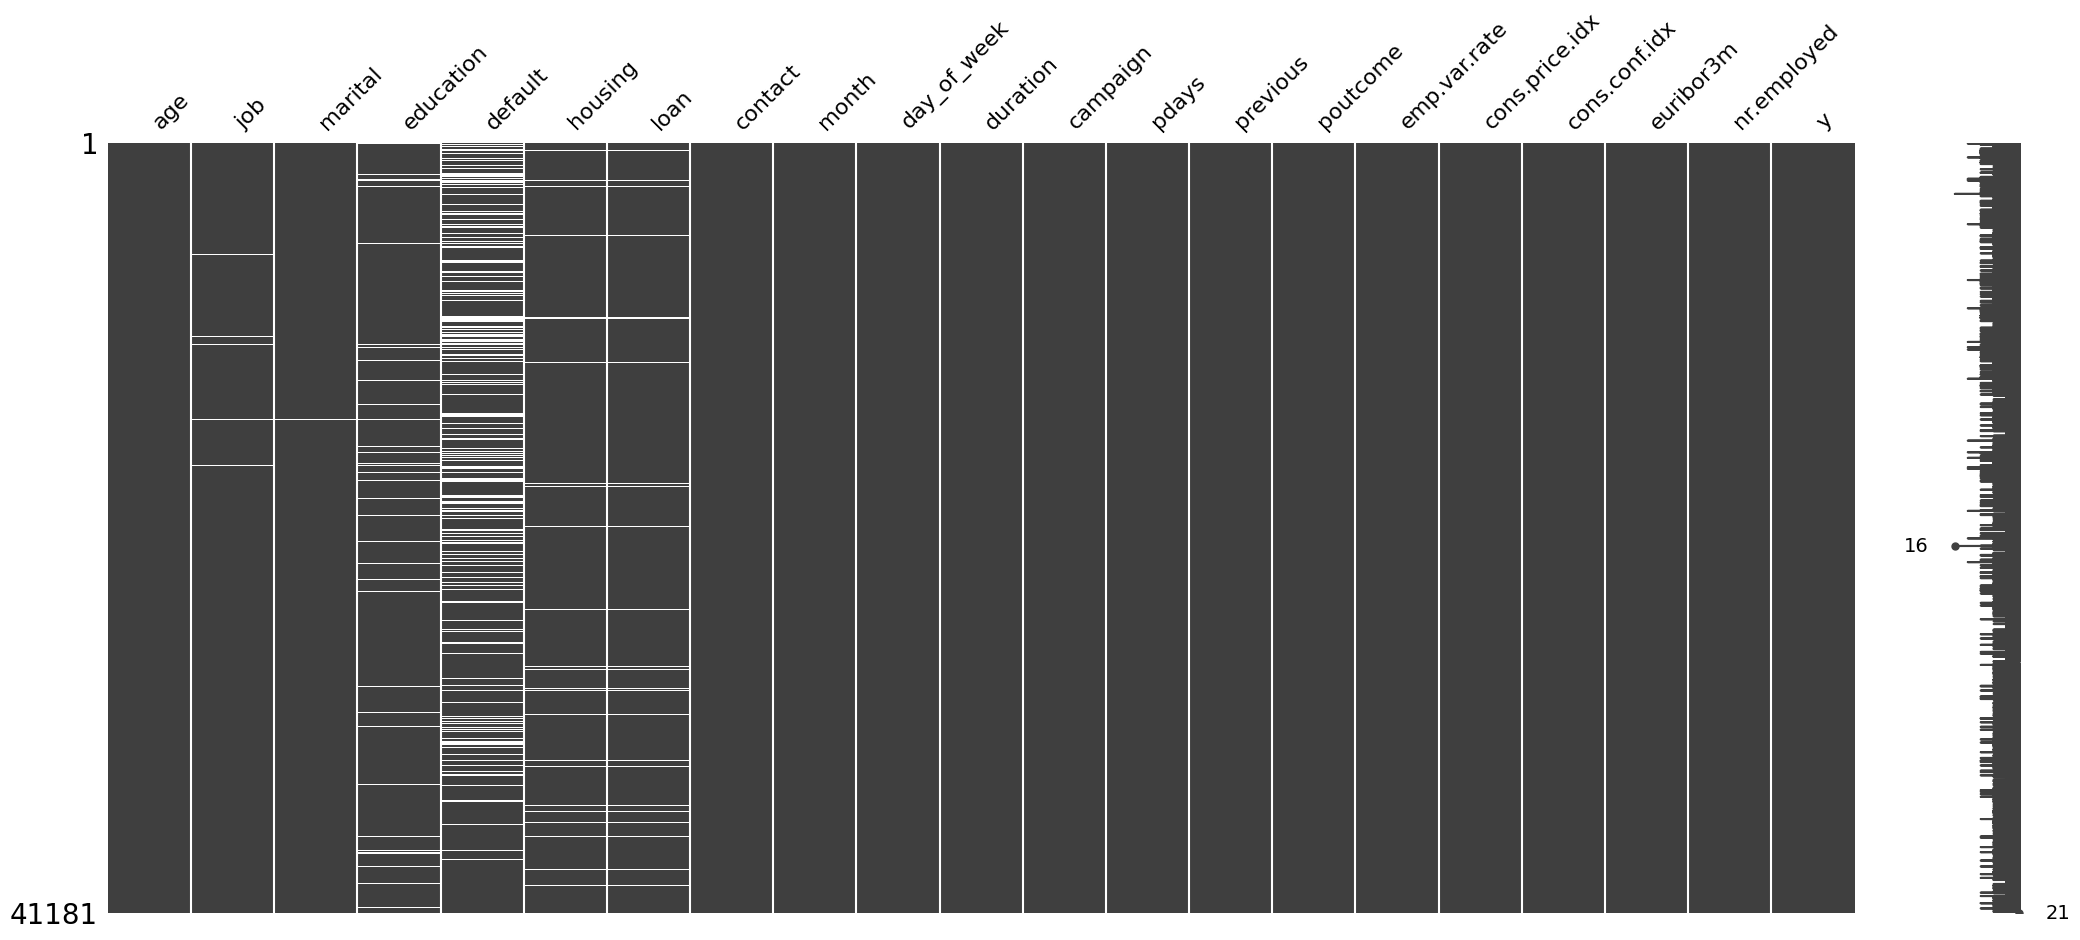

<Axes: >

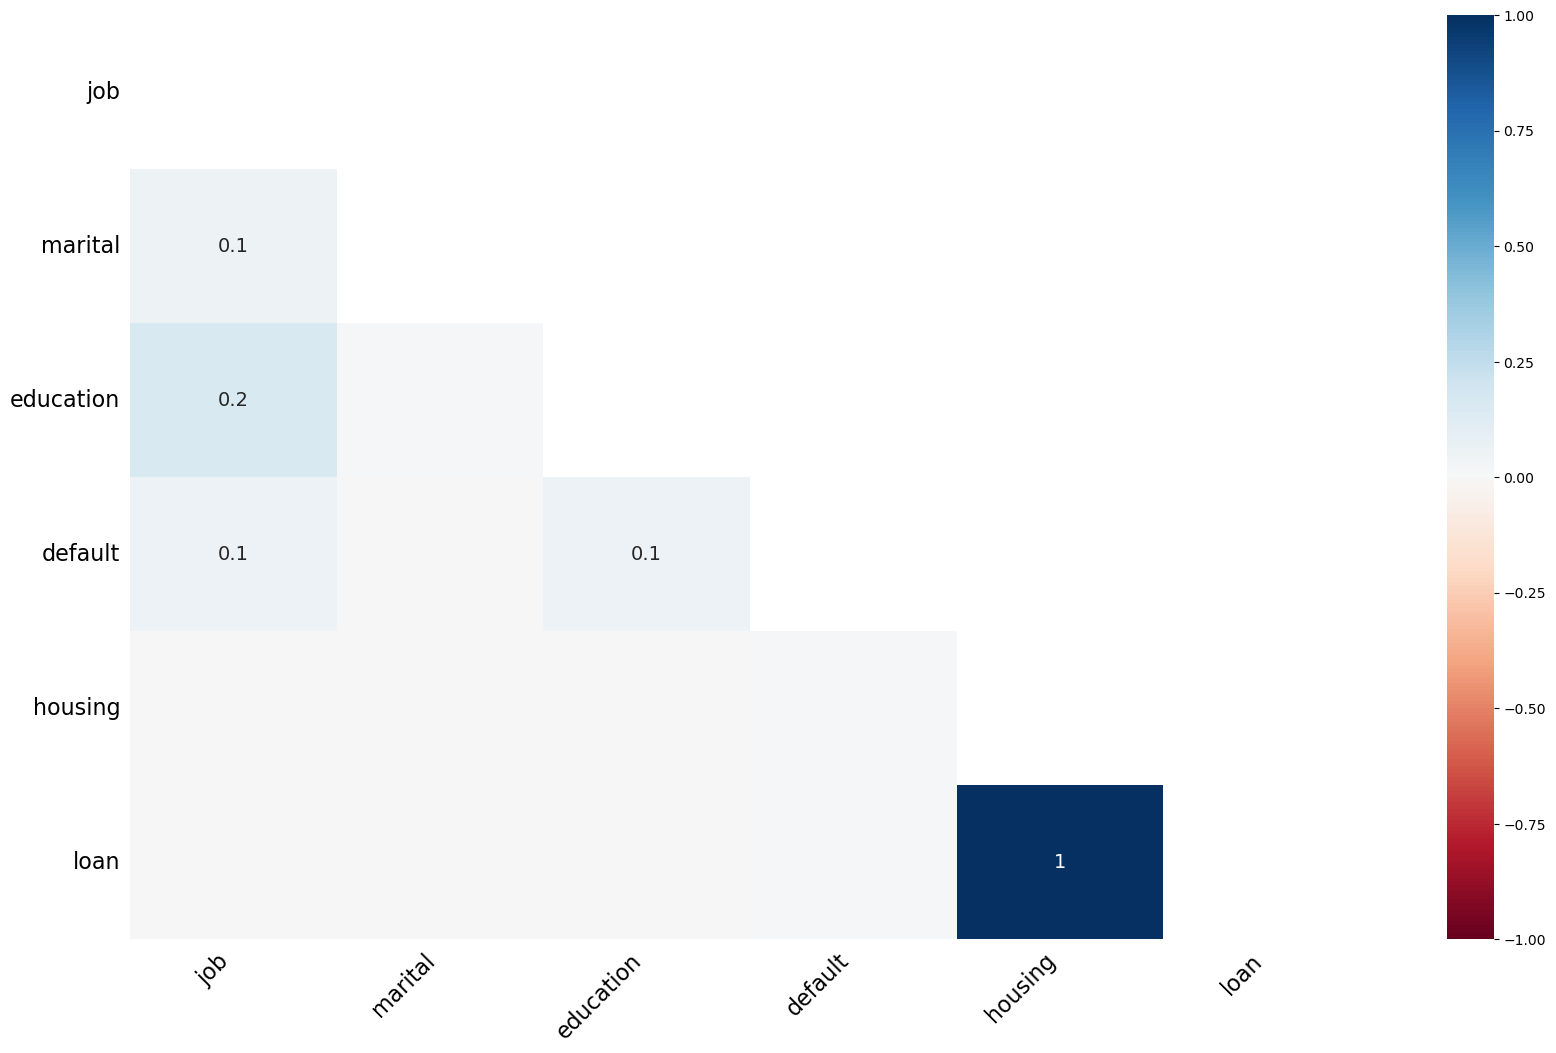

In [29]:
msno.heatmap(df)

There is a very high correlation of missing values for housing and loan. Perfect correlation value of 1 indicates missing values for each column occured simultaniously. This means housing and loan are missing not at random (MNAR)

Job and marital are missing completely at random (MCAR) as there is no correlation or clear pattern that exists.

In [30]:
# Percentage of missing
for col in columns_with_missing:
    print(col)
    print((df[col][df[col].isna()].shape[0]/df.shape[0])*100)

job
0.8013404239819335
marital
0.19426434520774144
education
4.200966465117408
default
20.876132196886914
housing
2.4040212719458003
loan
2.4040212719458003


In [31]:
print(df["default"].value_counts())
print(df["default"].isna().sum())

no     32581
yes        3
Name: default, dtype: int64
8597


Checking for pattern of matching between missing values of default and education

In [32]:
defa = df[df["default"].isna()].index
edu = df[df["education"].isna()].index
count= 0
for i in edu:
    if i in (defa):
        count+=1
print(count)
print(len(defa)-count)

548
8049


Checking for pattern of matching between missing values of default and housing and thus loan as well

In [33]:
defa = df[df["default"].isna()].index
edu = df[df["housing"].isna()].index
count= 0
for i in range(len(edu)):
    if edu[i] in (defa):
        count+=1
print(count)
print(len(defa)-count)

227
8370


Education seems to be either MAR or MCAR

**Missing percentage of default is very high but more importantly the yes percentage is extremely low especially compared to unknown values thus it could be converted back to a category and leave it.**

In [34]:
df["default"]=df["default"].astype(object)

In [35]:
df["default"]=df["default"].fillna("unknown")

In [36]:
df["default"]=df["default"].astype("category")

In [37]:
df["default"].isna().sum()

0

Due to findings mentioned above I decided to drop missing values in job, marital and education.

In [38]:
df.dropna(axis=0,how="any",subset=["job","marital","education"],inplace=True)

Since housing and loan are MNAR , removing the missing values might cause bias in the model. Also with MNAR the most appropriate action is to impute using a model and not mean median etc. I have chosen KNNmputer.

In [39]:
imputer = KNNImputer()

As there are columns with string dtype I will make imputation after encoding etc.

Jump Destination <a class="anchor" id="before_imputation"></a> <br> <br> Click Below To Jump <br> <br>
[Jump to Imputation](#imputation)

In [40]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### 1.4 Handling Outliers <a class="anchor" id="1.4"></a>

In [41]:
df.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

In [42]:
for col in ["age","duration","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]:
    Q1=df[col].quantile(q=0.25)
    Q3=df[col].quantile(q=0.75)
    lower = Q1-(1.5)*(Q3-Q1)
    upper = Q3+(1.5)*(Q3-Q1)
    print(col,lower,upper)

age 9.5 69.5
duration -223.5 644.5
emp.var.rate -6.6000000000000005 6.200000000000001
cons.price.idx 91.69650000000001 95.3725
cons.conf.idx -52.150000000000006 -26.949999999999992
euribor3m -4.081499999999999 10.3865
nr.employed 4905.6 5421.6


In [43]:
df[["age","duration","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]].describe()

,age,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,39185.000000,39185.000000,39185.000000,39185.000000,39185.000000,39185.000000,39185.000000
mean,39.858594,258.007120,0.083318,93.571761,-40.537175,3.623714,5167.406454
std,10.288634,259.744484,1.566455,0.577044,4.621794,1.730464,71.788692
min,17.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,179.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [44]:
for col in ["age","duration"]:
    Q1=df[col].quantile(q=0.25)
    Q3=df[col].quantile(q=0.75)
    lower = Q1-(1.5)*(Q3-Q1)
    upper = Q3+(1.5)*(Q3-Q1)
    df.drop(df[(df[col]<lower) | (df[col]>upper)].index,inplace=True)

In [45]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,281,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,112,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no


<font size ="5"> **Dropping duration column to have a realistic predictive model. Reasoning is the same as it was explained on the data description screenshot of the readme file of the downloaded data. For reference attached screenshot in the top of the notebook can be used.**

In [46]:
df.drop(columns=["duration"],inplace=True)

### 1.5 EDA After Cleaning <a class="anchor" id="1.5"></a>

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>,
        <Axes: title={'center': 'cons.price.idx'}>],
       [<Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>,
        <Axes: title={'center': 'nr.employed'}>]], dtype=object)

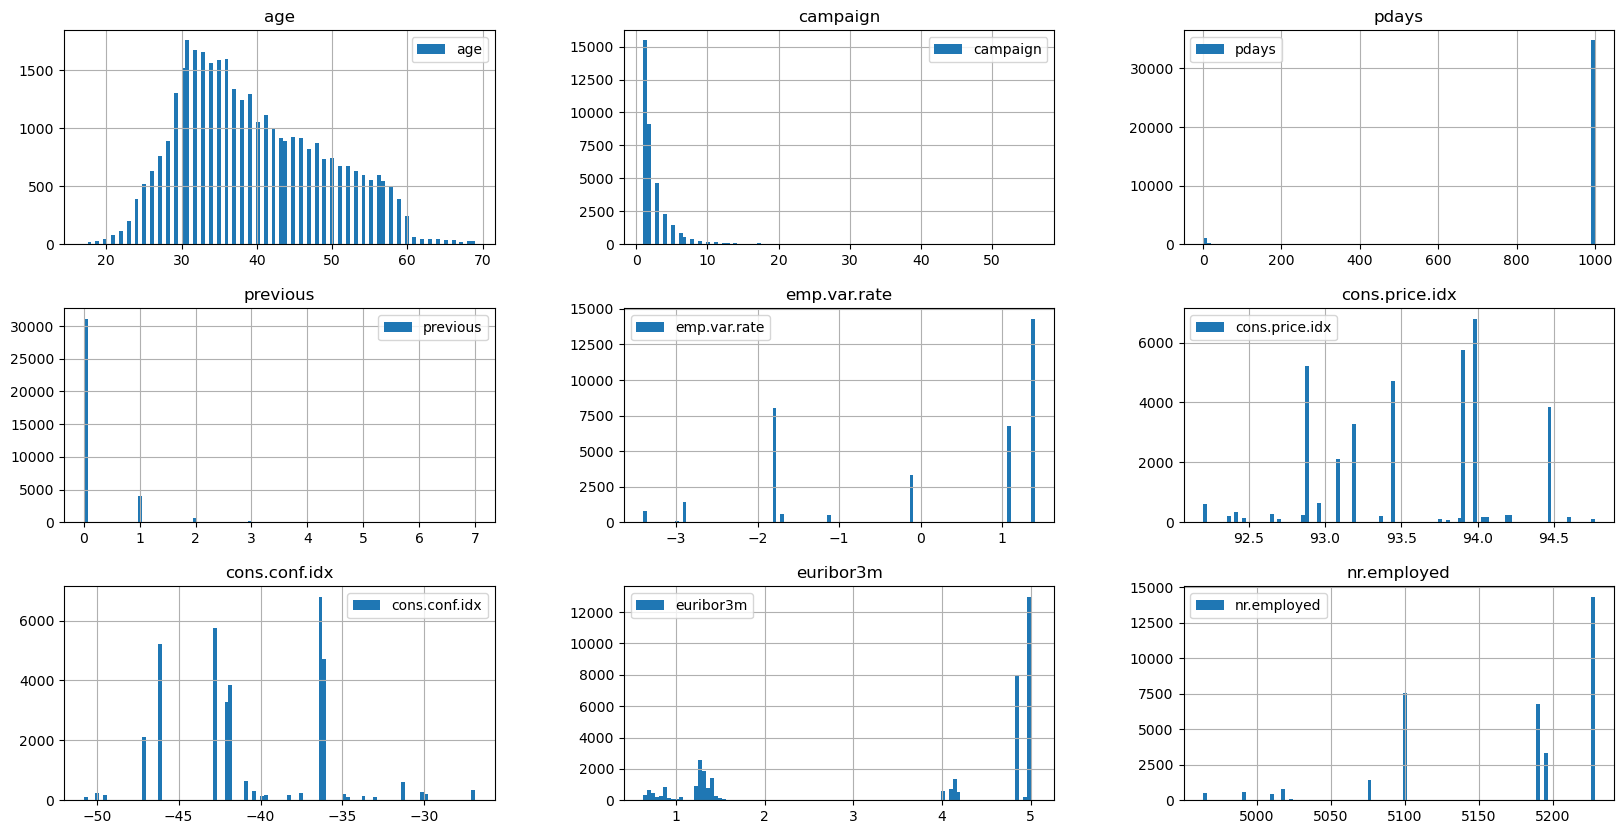

In [47]:
df.hist(figsize=(20,10),legend=True,bins=100)

In [48]:
df["pdays"].value_counts()

999    34760
3        342
6        328
4         97
2         51
9         48
12        47
7         46
10        43
5         37
13        26
1         22
11        21
15        18
14        14
0         13
8         13
16         7
17         6
18         5
22         3
21         2
25         1
26         1
27         1
19         1
Name: pdays, dtype: int64

None of the data are normally(near normally) distributed.

Text(0.5, 1.0, 'Target Distribution')

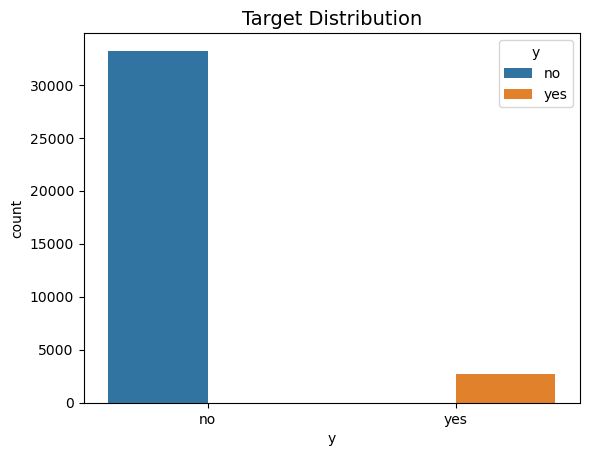

In [49]:
sns.countplot(data=df,x="y",hue="y")
plt.title("Target Distribution", fontsize=14)

Bivariate Analysis: Relationships of Categorical Features with Target

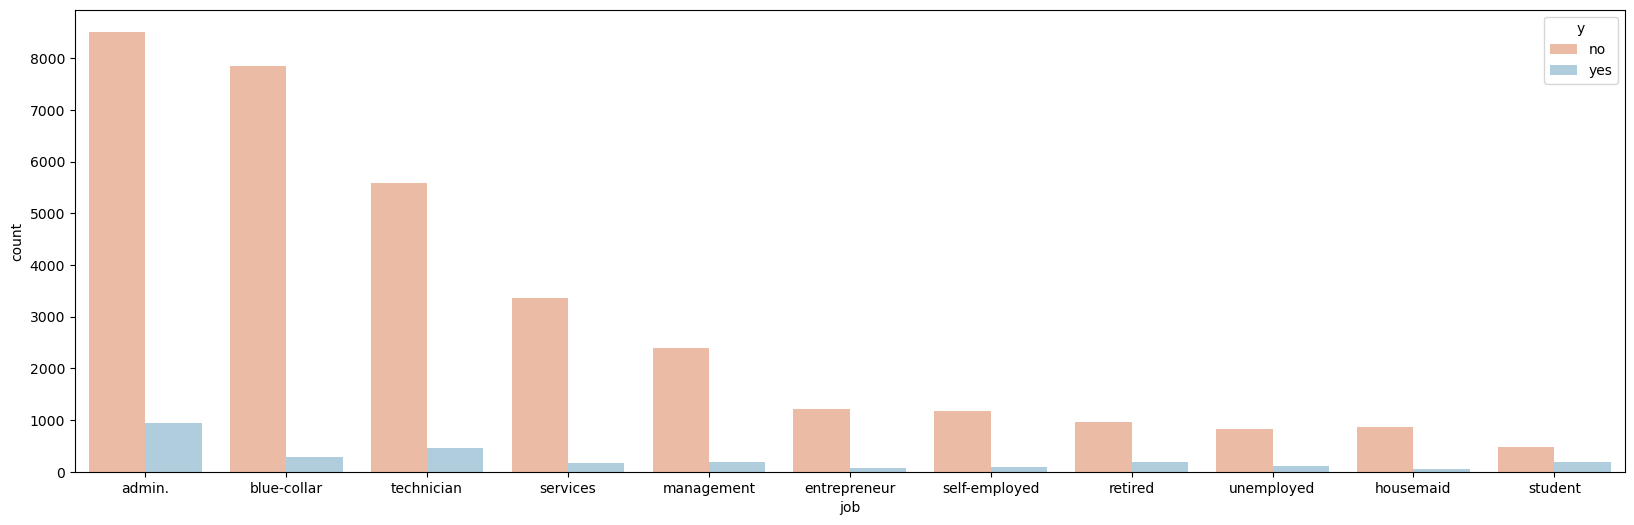

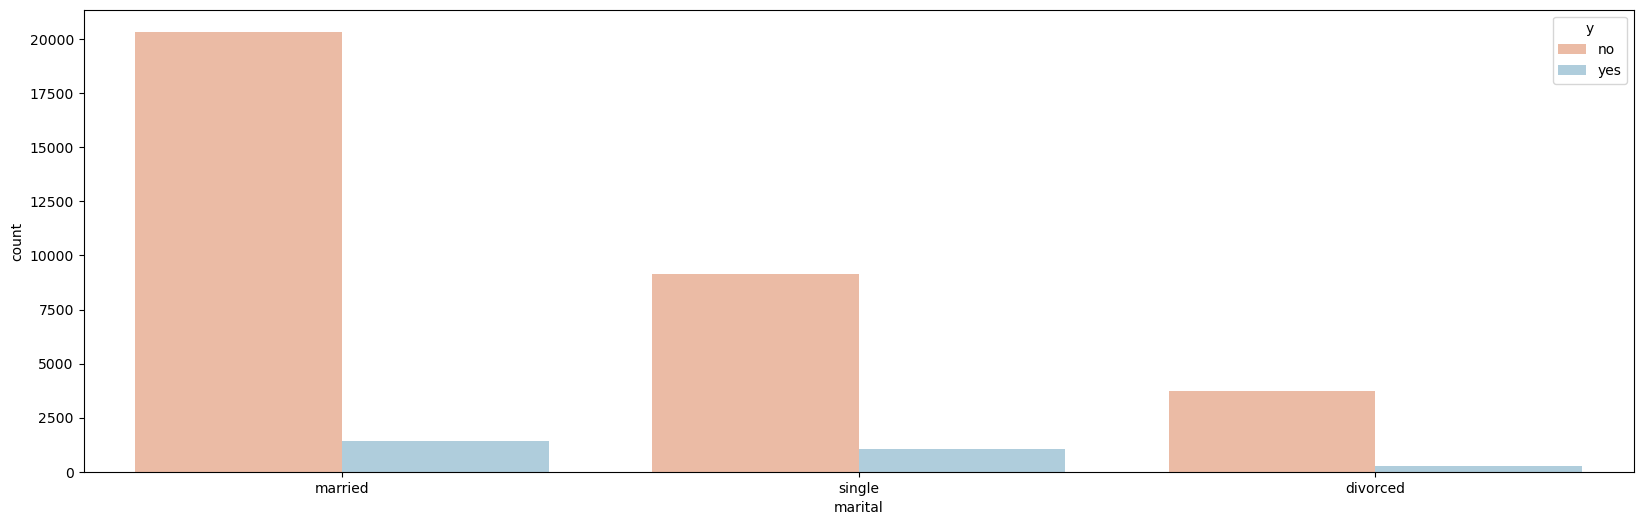

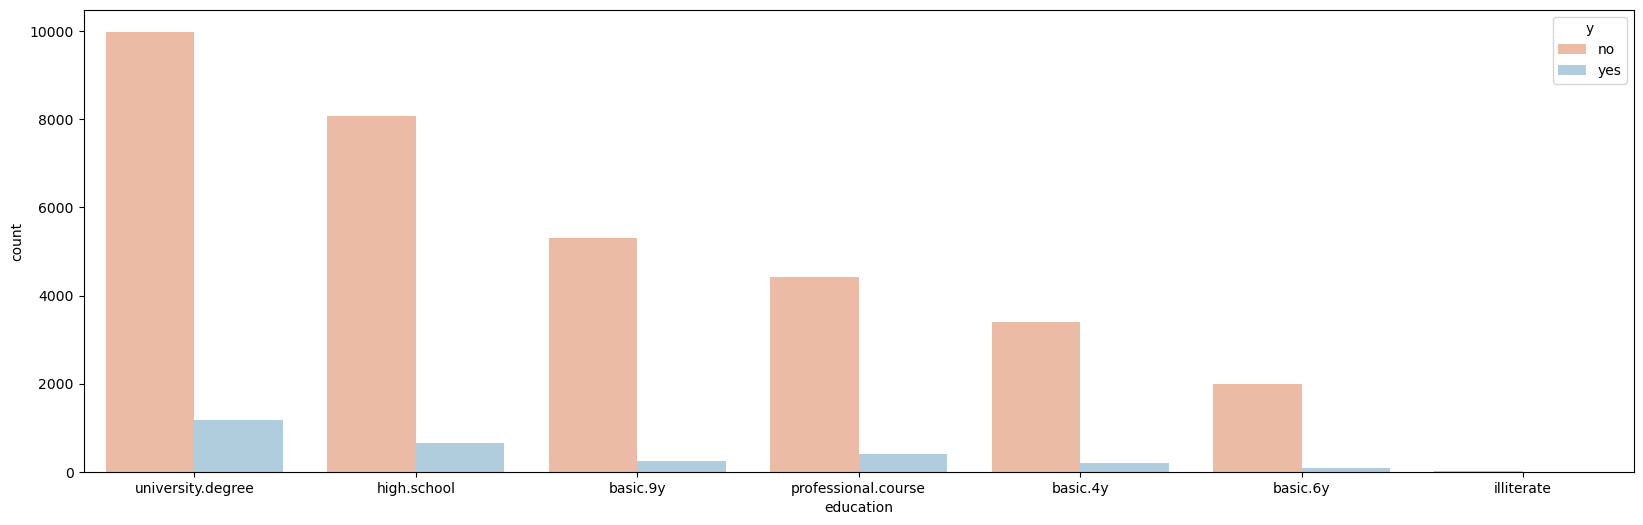

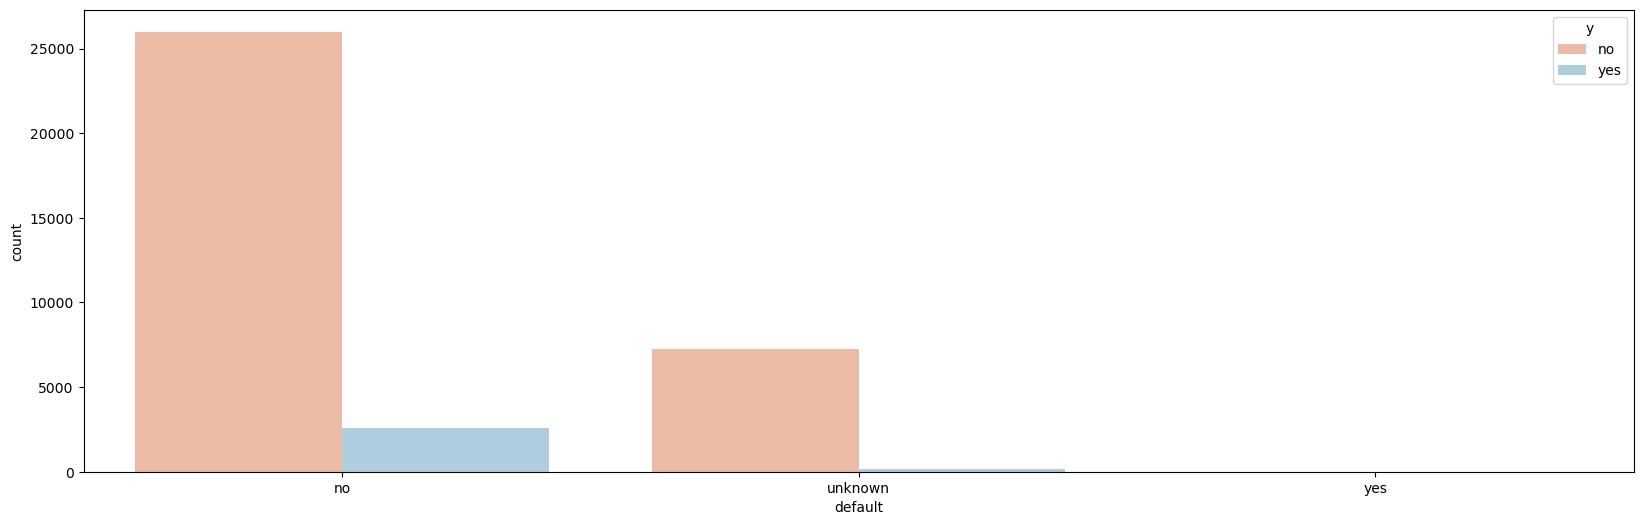

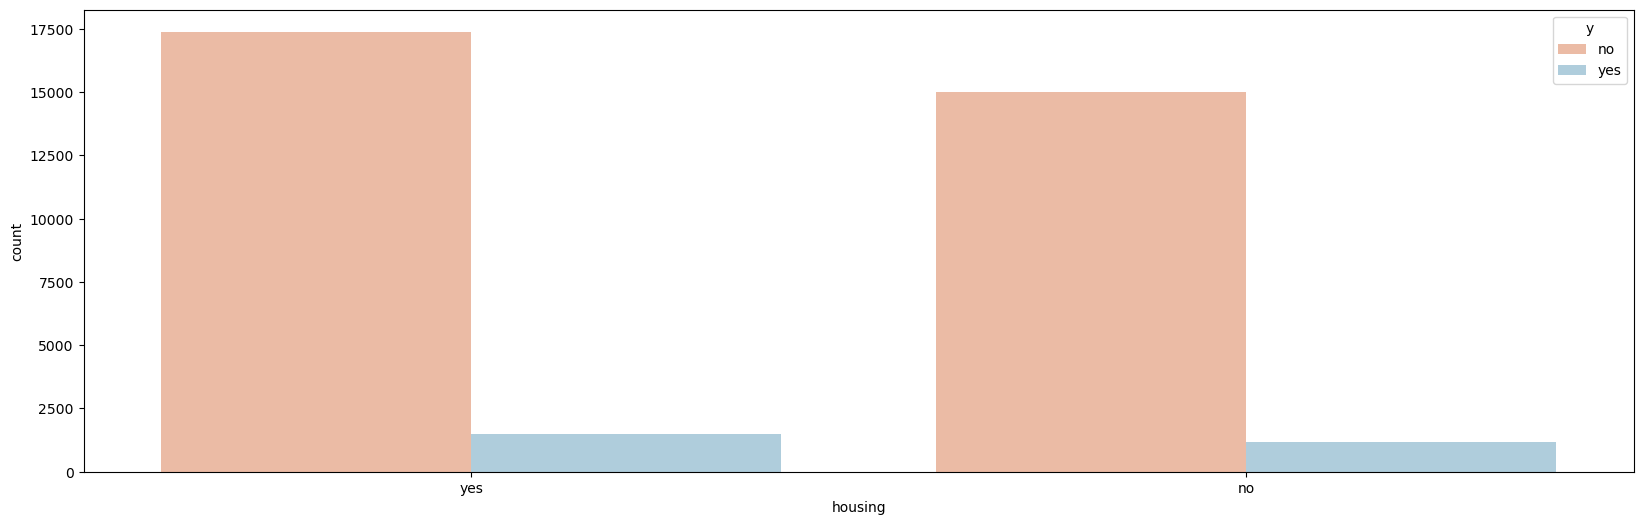

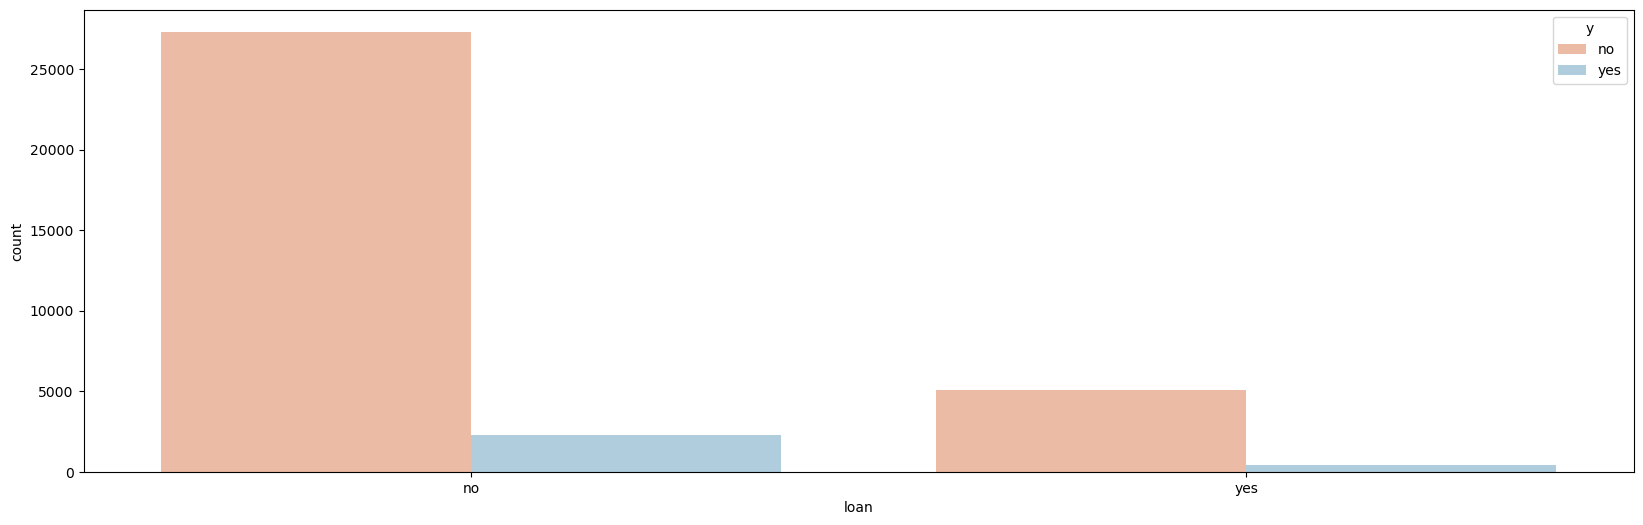

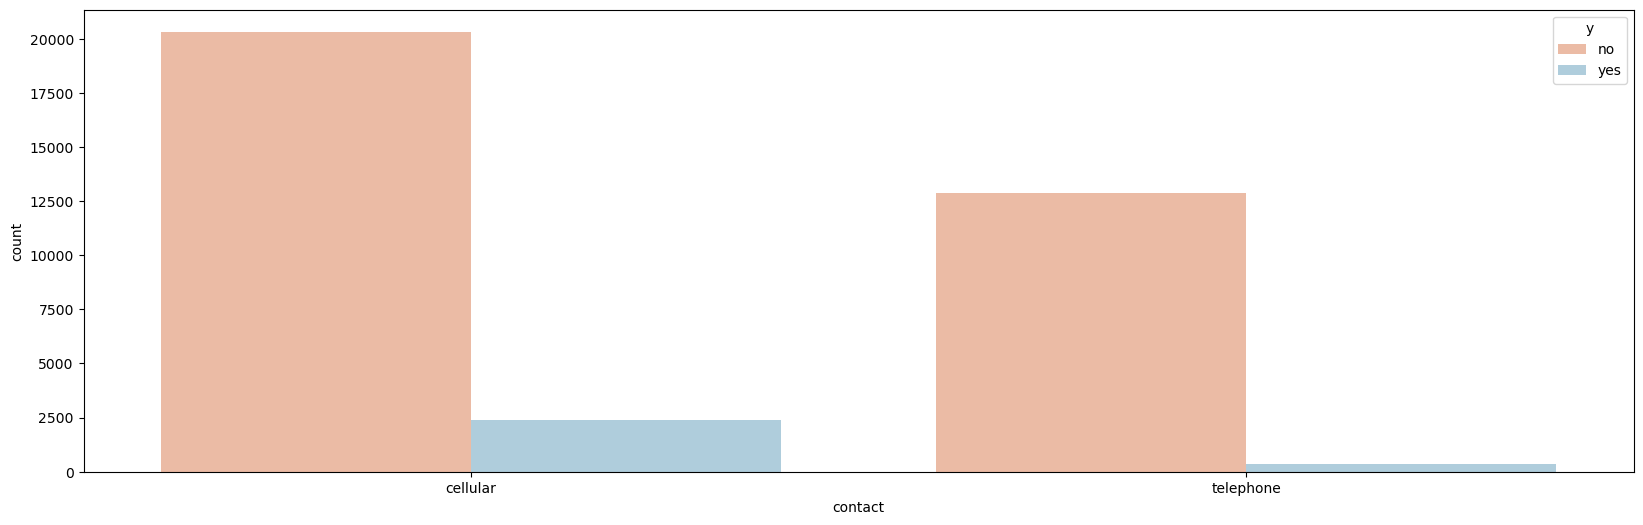

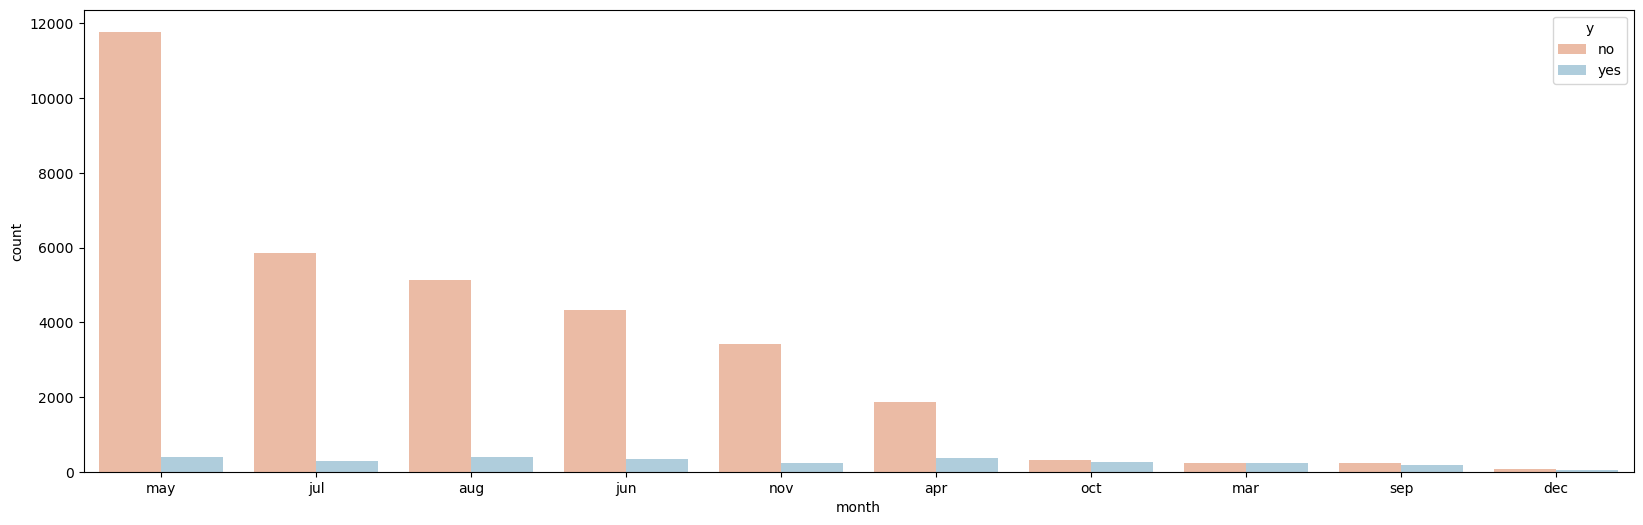

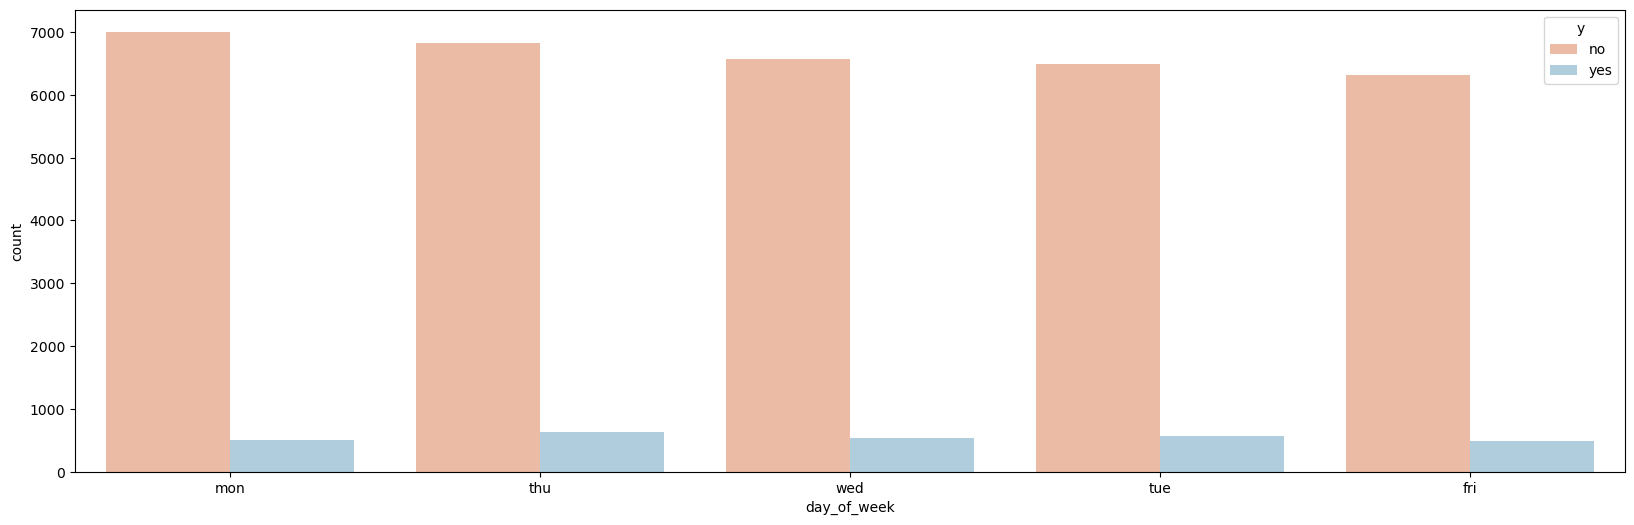

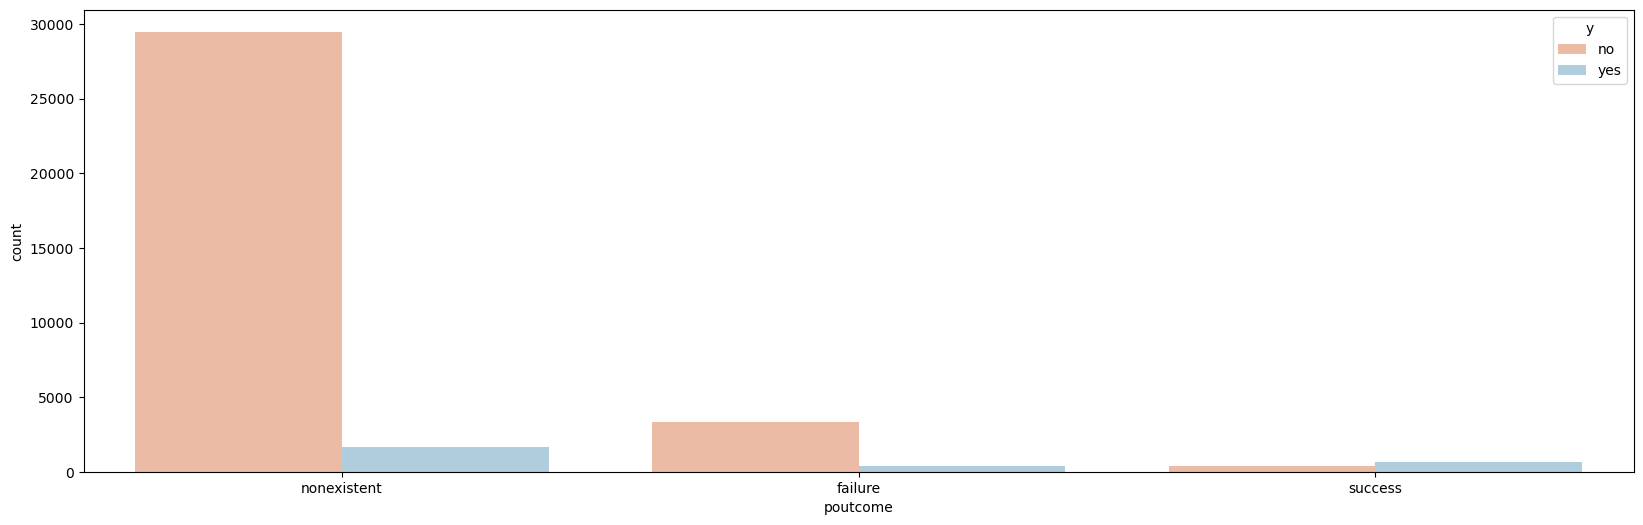

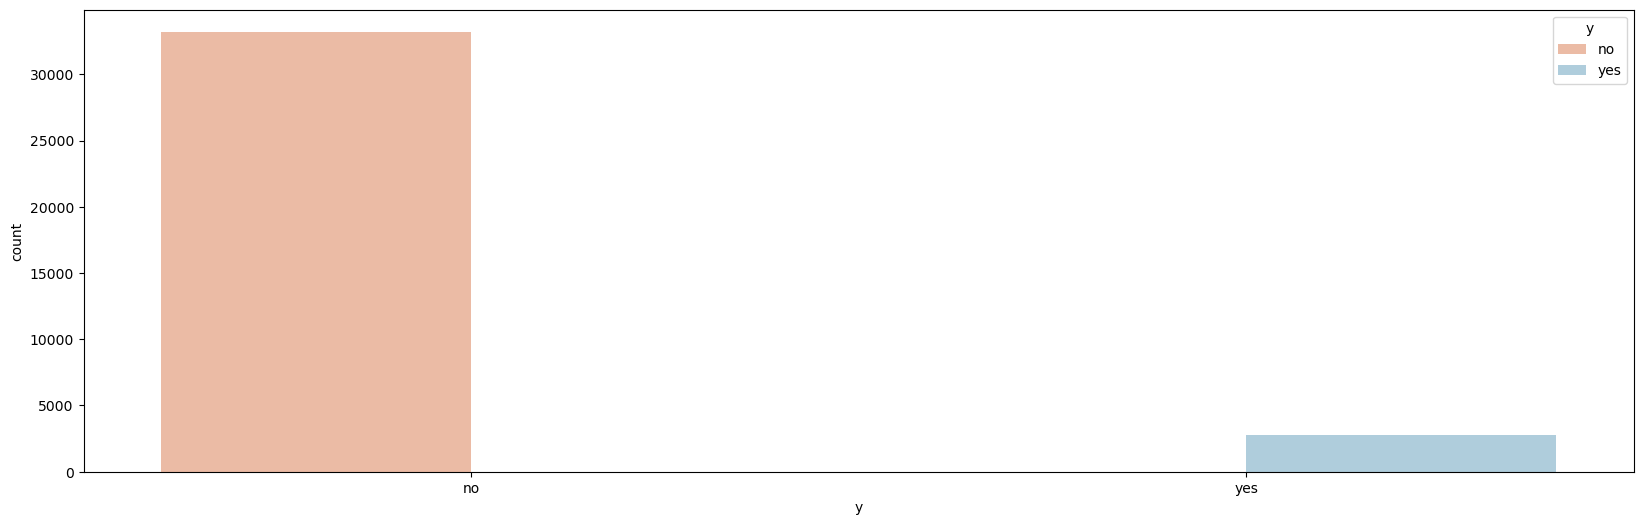

In [50]:
for c in df.dtypes[df.dtypes == "category"].index:
    plt.figure(figsize=(20,6))
    sns.countplot(x =c, hue="y",data = df,order = df[c].value_counts().index,palette="RdBu")

<Axes: xlabel='y', ylabel='pdays'>

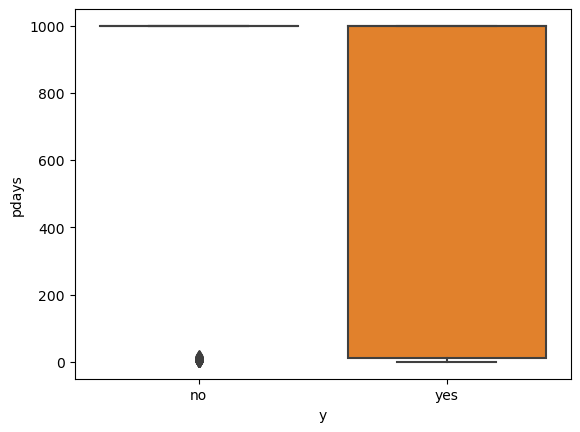

In [51]:
sns.boxplot(data=df,x="y",y="pdays")

Text(0.5, 1.0, 'Target Distribution for pdays')

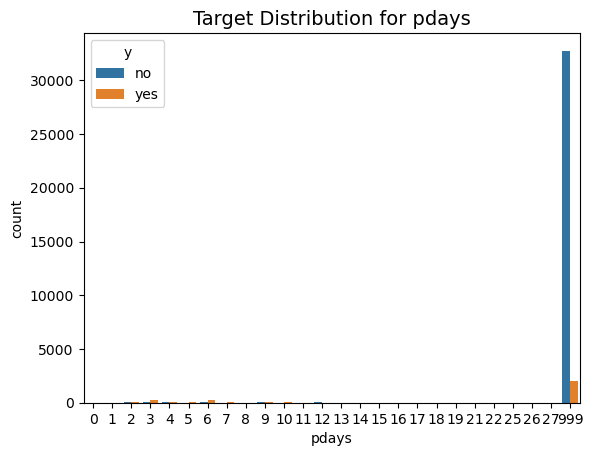

In [52]:
sns.countplot(data=df,x="pdays",hue="y")
plt.title("Target Distribution for pdays", fontsize=14)

In [53]:
df[["y","pdays"]].groupby("pdays").value_counts()

pdays  y  
0      yes        8
       no         5
1      no        16
       yes        6
2      yes       29
       no        22
3      yes      229
       no       113
4      no        50
       yes       47
5      yes       21
       no        16
6      yes      223
       no       105
7      yes       31
       no        15
8      yes        8
       no         5
9      no        26
       yes       22
10     yes       25
       no        18
11     no        12
       yes        9
12     no        31
       yes       16
13     yes       20
       no         6
14     yes        9
       no         5
15     yes       13
       no         5
16     yes        4
       no         3
17     no         5
       yes        1
18     no         3
       yes        2
19     no         1
       yes        0
21     yes        2
       no         0
22     yes        2
       no         1
25     yes        1
       no         0
26     yes        1
       no         0
27     yes        1
       no

In [54]:
pd.set_option('display.max_rows', 500)

In [55]:
print(df[["y","campaign","previous"]].groupby(["previous","campaign"]).value_counts())

previous  campaign  y  
0         1         no     12156
                    yes      876
          2         no      7375
                    yes      408
          3         no      3963
                           ...  
7         42        yes        0
          43        no         0
                    yes        0
          56        no         0
                    yes        0
Length: 672, dtype: int64


In [56]:
pd.reset_option('display.max_rows')

## 2. Data Preprocessing <a class="anchor" id="2"></a>

Creating a copy to use for tree-based etc. models because for a dummy variable, there is only one possible split and this induces sparsity

In [57]:
df_tree = df.copy()
#df_tree.drop(columns=["duration"],inplace=True)
df_tree.dropna(axis=0,how="any",inplace=True) # I cant impute with string values in the dataframe so for df_tree
# I decided to drop rows with housing or loan missing values.

In [58]:
for col in df.columns:
    if df[col].dtype=="category":
        print(col)
        print(df[col].unique())
        print()

job
['housemaid', 'services', 'admin.', 'technician', 'blue-collar', ..., 'management', 'unemployed', 'self-employed', 'entrepreneur', 'student']
Length: 11
Categories (11, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'services', 'student', 'technician', 'unemployed']

marital
['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']

education
['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'university.degree', 'illiterate']
Categories (7, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree']

default
['no', 'unknown', 'yes']
Categories (3, object): ['no', 'unknown', 'yes']

housing
['no', 'yes', NaN]
Categories (2, object): ['no', 'yes']

loan
['no', 'yes', NaN]
Categories (2, object): ['no', 'yes']

contact
['telephone', 'cellular']
Categories (2, object): ['cellular', 'telephone']

month
['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec

Education column contents are hierarchical thus can be replaced with incrementing numerical values

In [59]:
df["education"].replace(to_replace="illiterate",value=0,inplace=True)
df["education"].replace(to_replace="basic.4y",value=1,inplace=True)
df["education"].replace(to_replace="basic.6y",value=2,inplace=True)
df["education"].replace(to_replace="basic.9y",value=3,inplace=True)
df["education"].replace(to_replace="high.school",value=4,inplace=True)
df["education"].replace(to_replace="university.degree",value=5,inplace=True)
df["education"].replace(to_replace="professional.course",value=6,inplace=True)

In [60]:
df["education"]=df["education"].astype("int64")

In [61]:
months={"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

In [62]:
df["month"]=df["month"].map(months)

In [63]:
df["month"]=df["month"].astype("Int64")

In [64]:
df["month"]=df["month"].astype("int64")

In [65]:
days={'fri':5, 'mon':1, 'thu':4, 'tue':2, 'wed':3}

In [66]:
df["day_of_week"]=df["day_of_week"].map(days)

In [67]:
df["day_of_week"]=df["day_of_week"].astype("Int64")

In [68]:
df["day_of_week"]=df["day_of_week"].astype("int64")

In [69]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,1,no,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,4,unknown,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,4,no,yes,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,2,no,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,4,no,no,yes,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,5,no,yes,no,cellular,11,5,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41182,29,unemployed,single,1,no,yes,no,cellular,11,5,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no
41184,46,blue-collar,married,6,no,no,no,cellular,11,5,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,5,no,yes,no,cellular,11,5,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no


In [70]:
df_pip = df.copy() # to be used later for pipeline

<font size="5"> **Scaling**

<font size="4"> Data is not normally distributed so a scalar like standardscaler. MinMaxScaler seems to be a good idea as each value will fall between 0 and 1 making the numeric columns in harmony with encoded columns. Note the one column with negative values will ofcourse be converted between -1 and 1

In [71]:
scaler = MinMaxScaler()

In [72]:
cols_to_scale=[]
for col in df.columns:
    if df[col].dtype=="int64" or df[col].dtype=="float64":
        cols_to_scale.append(col)
cols_to_scale.remove("pdays") # I wont scale pdays as I have plans for it in feature selection

In [73]:
df[cols_to_scale]=scaler.fit_transform(df[cols_to_scale])

<font size="4"> LabelEncoder -> This transformer should be used to encode target values, i.e. y, and not the input X. But upon research I concluded in this special case where all the columns below have 2 different values, there wont be a problem. <br>
source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [74]:
le = LabelEncoder()
for col in ["housing","loan","contact","y"]:
    df[col] = le.fit_transform(df[col])

## 3. Feature Engineering  (Contains Feature Selection) <a class="anchor" id="3"></a>

After results obtained from EDA, I decided to adjust pdays into a new variable and remove pdays.

I am dropping pdays which is part of feature selection

In [75]:
df["contacted_before"] = np.where(df["pdays"]!= 999, 1, 0)
df.drop(columns=["pdays"],axis=1,inplace=True)

In [76]:
dummies=pd.get_dummies(df[["marital","default","poutcome","job"]])
dummies

,marital_divorced,marital_married,marital_single,default_no,default_unknown,default_yes,poutcome_failure,poutcome_nonexistent,poutcome_success,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
41182,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
41184,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
41185,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


<font size ="4"> **Because of dummy variable trap, to avoid multicolinearity I am dropping one of the dummy variables for each column**

In [77]:
dummies.drop(["marital_divorced","default_unknown","poutcome_nonexistent","job_unemployed"],axis=1,inplace=True)

In [78]:
df = df.join(dummies)

In [79]:
df.drop(["marital","default","poutcome","job"],axis=1,inplace=True)

In [80]:
df.head()

,age,education,housing,loan,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contacted_before,marital_married,marital_single,default_no,default_yes,poutcome_failure,poutcome_success,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician
0,0.750000,0.166667,0,0,1,0.222222,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.769231,0.666667,0,0,1,0.222222,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.384615,0.666667,1,0,1,0.222222,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.442308,0.333333,0,0,1,0.222222,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.750000,0.666667,0,1,1,0.222222,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [81]:
df2 = df.copy()

Jump Destination <a class="anchor" id="imputation"></a> <br> <br>
[Jump Back](#before_imputation)

In [82]:
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [83]:
df.isna().sum()

age                  0
education            0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
previous             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
contacted_before     0
marital_married      0
marital_single       0
default_no           0
default_yes          0
poutcome_failure     0
poutcome_success     0
job_admin.           0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
dtype: int64

In [84]:
df["y"].value_counts()

0.0    33217
1.0     2736
Name: y, dtype: int64

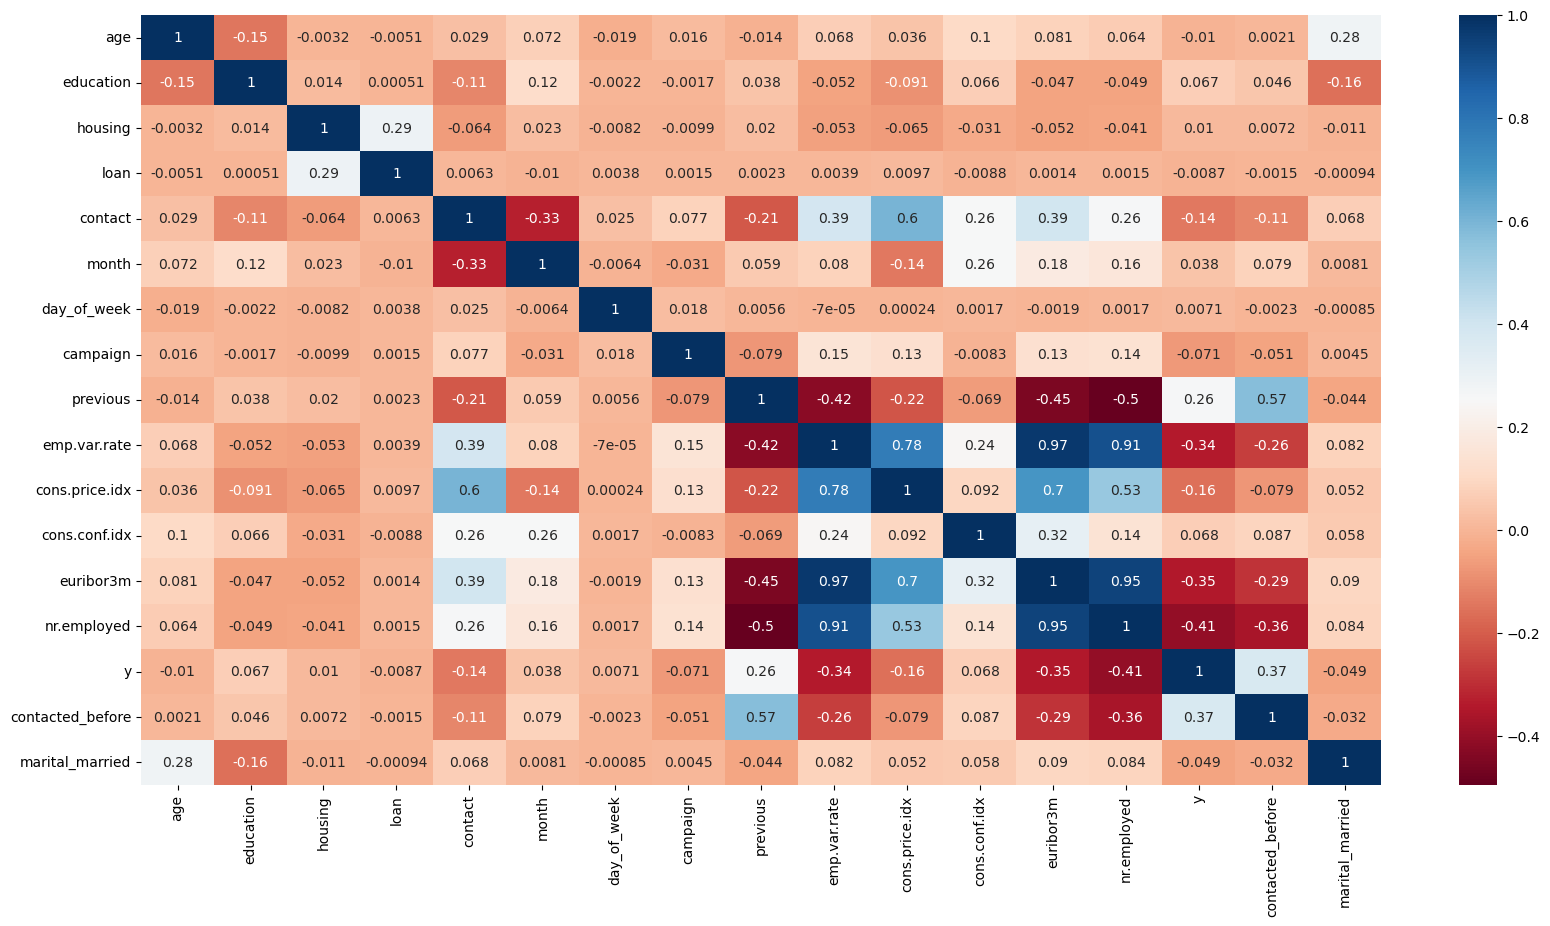

In [85]:
plt.figure(figsize=(20,10))
sns.heatmap(df.iloc[:,0:17].corr(numeric_only=True), annot=True,cmap='RdBu')
plt.show()

<font size ="4"> Linear Regression, Logistic Regression, KNN, and Naive Bayes algorithms are impacted by multicollinearity

Before dropping its important to check vif before and after introducing a new column that is made from the multiplication of the independent variables that have high correlation.

Below are the guidelines to interpret the VIF: <br> 

VIF = 1 (Not correlated) 1 < VIF < 5 (Moderately correlated) VIF >=5 (Highly correlated) VIF >=10 (Problematicly correlated)

In [86]:
XC = add_constant(df)

In [87]:
pd.Series([variance_inflation_factor(XC.values, i) 
               for i in range(XC.shape[1])], 
              index=XC.columns)

const                245.461942
age                    1.476638
education              1.735195
housing                1.100104
loan                   1.093627
contact                2.728108
month                  2.016590
day_of_week            1.003846
campaign               1.035805
previous               6.053251
emp.var.rate          46.392179
cons.price.idx         9.298886
cons.conf.idx          2.965946
euribor3m             86.724038
nr.employed           33.452902
y                      1.356089
contacted_before      12.711423
marital_married        2.604865
marital_single         2.899811
default_no             1.149371
default_yes            1.001309
poutcome_failure       4.218082
poutcome_success      11.141442
job_admin.             8.320770
job_blue-collar        7.871305
job_entrepreneur       2.314762
job_housemaid          1.989052
job_management         3.548534
job_retired            2.296360
job_self-employed      2.294000
job_services           4.350617
job_stud

df_linear = df.drop(columns=["emp.var.rate","euribor3m"])

In [88]:
df["test"] = df["emp.var.rate"]*df["euribor3m"]

In [89]:
XC = add_constant(df)

In [90]:
pd.Series([variance_inflation_factor(XC.values, i) 
               for i in range(XC.shape[1])], 
              index=XC.columns)

const                470.114635
age                    1.477594
education              1.735642
housing                1.100109
loan                   1.093663
contact                3.039350
month                  2.115794
day_of_week            1.006348
campaign               1.042214
previous               6.054341
emp.var.rate          65.798376
cons.price.idx        12.615807
cons.conf.idx          6.808133
euribor3m             91.072003
nr.employed           49.006198
y                      1.358620
contacted_before      12.726631
marital_married        2.604912
marital_single         2.900970
default_no             1.149489
default_yes            1.001325
poutcome_failure       4.225752
poutcome_success      11.156725
job_admin.             8.320993
job_blue-collar        7.871314
job_entrepreneur       2.315008
job_housemaid          1.989556
job_management         3.549463
job_retired            2.298473
job_self-employed      2.294022
job_services           4.350623
job_stud

In [91]:
df.drop(columns=["test"],inplace=True)

**Using PCA to handle multicolinearity as unsupervised feature selection**

Since both emp.var.rat and euribor3m columns were scaled there is no need to scale before PCA

Later this was not usefull thus removed but a copy of it with expendable dataframe was added to notebook for demonstration reasons.

In [92]:
pca = PCA()
pc_df = df[["emp.var.rate","euribor3m"]]
pc = pca.fit_transform(pc_df)
pc_df = pd.DataFrame(pc, columns=["emp.var.rate","euribor3m"])
test_df = df.copy()
test_df["emp.var.rate"] = pc_df["emp.var.rate"]
test_df["euribor3m"] = pc_df["euribor3m"]
XC = add_constant(test_df)
pd.Series([variance_inflation_factor(XC.values, i) 
               for i in range(XC.shape[1])], 
              index=XC.columns)

const                725.891836
age                    1.476638
education              1.735195
housing                1.100104
loan                   1.093627
contact                2.728108
month                  2.016590
day_of_week            1.003846
campaign               1.035805
previous               6.053251
emp.var.rate          55.497359
cons.price.idx         9.298886
cons.conf.idx          2.965946
euribor3m              2.668770
nr.employed           33.452902
y                      1.356089
contacted_before      12.711423
marital_married        2.604865
marital_single         2.899811
default_no             1.149371
default_yes            1.001309
poutcome_failure       4.218082
poutcome_success      11.141442
job_admin.             8.320770
job_blue-collar        7.871305
job_entrepreneur       2.314762
job_housemaid          1.989052
job_management         3.548534
job_retired            2.296360
job_self-employed      2.294000
job_services           4.350617
job_stud

Creating a new variable of the two highly correlated columns to keep before dropping the two to have a less reduction in interpretibility.

In [93]:
df_linear = df.copy()

In [94]:
df_linear["test"] = df_linear["emp.var.rate"]*df_linear["euribor3m"]
df_linear.drop(columns=["emp.var.rate","euribor3m"],inplace=True)

In [95]:
XC = add_constant(df_linear)

In [96]:
pd.Series([variance_inflation_factor(XC.values, i) 
               for i in range(XC.shape[1])], 
              index=XC.columns)

const                356.241084
age                    1.477115
education              1.733798
housing                1.099943
loan                   1.093564
contact                2.660877
month                  1.519470
day_of_week            1.004003
campaign               1.030900
previous               6.019675
cons.price.idx        12.293799
cons.conf.idx          5.647896
nr.employed           37.633068
y                      1.341782
contacted_before      12.708194
marital_married        2.604161
marital_single         2.899211
default_no             1.149264
default_yes            1.001292
poutcome_failure       4.219761
poutcome_success      11.153089
job_admin.             8.319011
job_blue-collar        7.870342
job_entrepreneur       2.313780
job_housemaid          1.989335
job_management         3.546536
job_retired            2.297517
job_self-employed      2.293796
job_services           4.349994
job_student            1.749228
job_technician         6.451689
test    

In [97]:
df_linear.drop(columns=["test"],inplace=True)

In [98]:
XC = add_constant(df_linear)

pd.Series([variance_inflation_factor(XC.values, i) 
               for i in range(XC.shape[1])], 
              index=XC.columns)

const                102.662007
age                    1.476476
education              1.733781
housing                1.099684
loan                   1.093563
contact                2.089278
month                  1.463198
day_of_week            1.002771
campaign               1.028562
previous               6.009061
cons.price.idx         2.386300
cons.conf.idx          1.364507
nr.employed            2.407935
y                      1.339694
contacted_before      12.706667
marital_married        2.604141
marital_single         2.898966
default_no             1.148669
default_yes            1.001292
poutcome_failure       4.186221
poutcome_success      11.138622
job_admin.             8.316725
job_blue-collar        7.869132
job_entrepreneur       2.313741
job_housemaid          1.988127
job_management         3.546524
job_retired            2.296185
job_self-employed      2.293752
job_services           4.349283
job_student            1.749200
job_technician         6.446817
dtype: f

<font size="4"> I decided to conclude that multicolinearity where both contacted_before and poutcome_success parameters co-exist was unavoidable. **At this point I dont expect much from linear methods and most likely focus on tree models etc. I also decided to keep the two problematic parameter.**

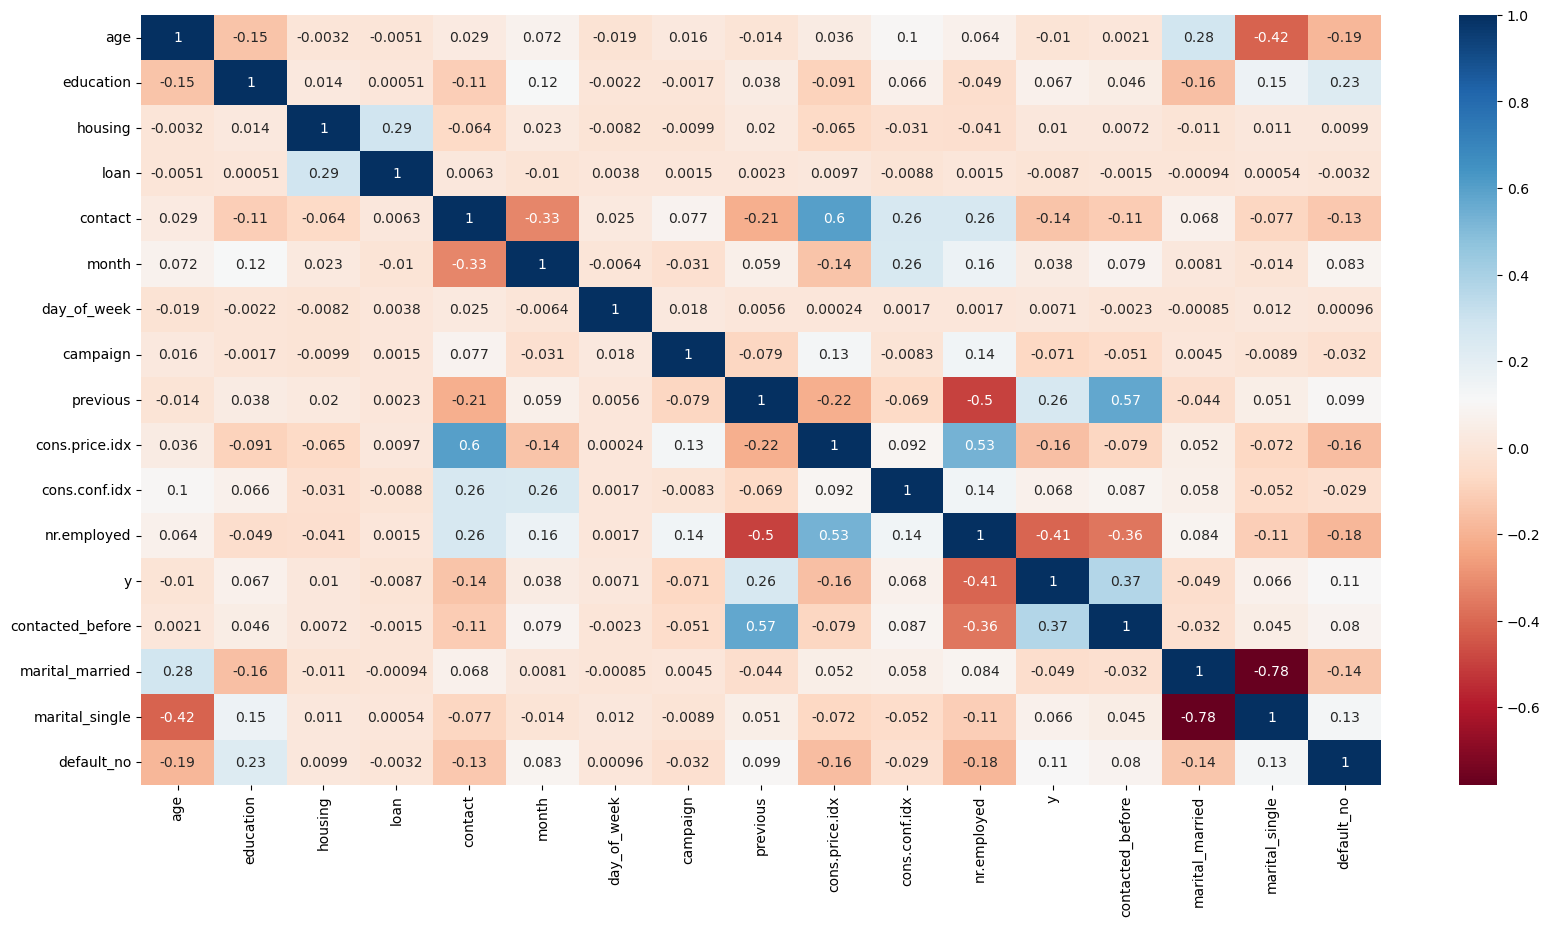

In [99]:
plt.figure(figsize=(20,10))
sns.heatmap(df_linear.iloc[:,0:17].corr(numeric_only=True), annot=True,cmap='RdBu')
plt.show()

<font size="5"> **I debated a lot in my head to whether I should combine campagin and previous columns into a single one while removing them in this section to increase computation speed while keeping relevant information which is total number of contacts from previous marketing campagins but there was a possibility that the previous campagin varied greatly in terms of execution and method than the campagin column, in simpler terms with an example the bank could have adapted a new type of marketing campagin strategy that was much more effective than before which will proceed to future calls to be predicted. For possibilities such as these deciding to combine the columns could have led to loss of interpretation thus I decided to leave the columns as it is. I am adding this information here as an evidence for grading purposes that I considered this for feature engineering**

## 4. Model Selection <a class="anchor" id="4"></a>

I wont focus to much on models like regression due to various reasons I have stated throughout the notebook.

Checking if the data is imbalanced

In [100]:
df["y"].value_counts()

0.0    33217
1.0     2736
Name: y, dtype: int64

Since the data is imbalanced train_test_split should be done with stratify=y to ensure balanced sampling.

In [101]:
df["y"] = df["y"].astype("int") #sckitlearn expects str or int labels
df2["y"] = df2["y"].astype("int") #sckitlearn expects str or int labels

In [102]:
X = df2.drop("y",axis=1).values
y = df2["y"].values

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [104]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)

In [108]:
data.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [109]:
df.month.unique()

array([0.22222222, 0.33333333, 0.44444444, 0.55555556, 0.77777778,
       0.88888889, 1.        , 0.        , 0.11111111, 0.66666667])

### 4.1 Ridge Regression <a class="anchor" id="4.1"></a>

**I wont go too deep in this model, its minor hypertuning tests performance (Which was removed from notebook) was poorer than others.**

In [660]:
X2 = df.drop("y",axis=1).values
y2 = df["y"].values
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.2,stratify=y,random_state=1)

Because of high multicolinearity it would be wise to check results of ridge and/or lasso regression.

Since the target(dependent variable) is binary. I need to use ridge classification. This will do the following as explained in documents: <br>
This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).



In [661]:
alpha_space = np.logspace(-4,0,100)
tol_space = np.linspace(0.0001, 1.0, 50)
param_grid = {"alpha":alpha_space,"tol":tol_space}

In [662]:
rc = RidgeClassifier(random_state=1)

In [663]:
rccv= GridSearchCV(rc,param_grid,cv=kf,scoring=["recall","roc_auc"],refit="recall")

In [664]:
rccv.fit(X_train2,y_train2)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RidgeClassifier(random_state=1),
             param_grid={'alpha': array([1.00000000e-04, 1.09749877e-04, 1.20450354e-04, 1.32194115e-04,
       1.45082878e-04, 1.59228279e-04, 1.74752840e-04, 1.91791026e-04,
       2.10490414e-04, 2.31012970e-04, 2.53536449e-04, 2.78255940e-04,
       3.05385551e-04, 3.35160265e-04, 3.6783797...
       5.71471429e-01, 5.91877551e-01, 6.12283673e-01, 6.32689796e-01,
       6.53095918e-01, 6.73502041e-01, 6.93908163e-01, 7.14314286e-01,
       7.34720408e-01, 7.55126531e-01, 7.75532653e-01, 7.95938776e-01,
       8.16344898e-01, 8.36751020e-01, 8.57157143e-01, 8.77563265e-01,
       8.97969388e-01, 9.18375510e-01, 9.38781633e-01, 9.59187755e-01,
       9.79593878e-01, 1.00000000e+00])},
             refit='recall', scoring=['recall', 'roc_auc'])

In [665]:
y_pred2 = rccv.predict(X_test2)

In [666]:
print(rccv.best_params_)
print(confusion_matrix(y_test2,y_pred2))

{'alpha': 0.0001, 'tol': 0.0001}
[[6586   58]
 [ 421  126]]


In [667]:
print("Accuracy: ",metrics.accuracy_score(y_test2, y_pred2))
print("Recall: ",metrics.recall_score(y_test2, y_pred2))
print("Precision: ",metrics.precision_score(y_test2, y_pred2))
print("CL Report: ",metrics.classification_report(y_test2, y_pred2))

Accuracy:  0.9333889584202475
Recall:  0.2303473491773309
Precision:  0.6847826086956522
CL Report:                precision    recall  f1-score   support

           0       0.94      0.99      0.96      6644
           1       0.68      0.23      0.34       547

    accuracy                           0.93      7191
   macro avg       0.81      0.61      0.65      7191
weighted avg       0.92      0.93      0.92      7191



In [146]:
Audio(sound_file, autoplay=True)

Recording the best params to use incase in the future kernel is reset <br>
print(rccv.best_params_) <br>
{'alpha': 0.0001, 'tol': 0.0001}

In [668]:
joblib.dump(rccv, 'rccv_obj.pkl')

['rccv_obj.pkl']

In [669]:
joblib_rccv = joblib.load("rccv_obj.pkl")

Despite properly spesifiying metrics the recall of the class 1, the model was unable to provide an efficent prediction. This is most likely due to data not being very suited for linear models.

### 4.2 Logistic Regression <a class="anchor" id="4.2"></a>

I wont go too deep in this model, its minor hypertuning tests performance (Which was removed from notebook) was poorer than others.

In [438]:
#X = df.drop(columns=["y"],axis=1).values
X2 = df.drop("y",axis=1).values
y2 = df["y"].values

In [439]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.2,stratify=y,random_state=1)

In [449]:
C = np.linspace(0.1, 1.0, 50)
class_weights = [{1:3,0:0.1},{1:1,0:0.1}]

In [451]:
param_grid={"C":C,"class_weight":class_weights}

param_grid = {"C": np.linspace(0.1, 1.0, 50),"class_weight":{1:3,0:0.1} }

In [452]:
logreg = LogisticRegression(solver='lbfgs', max_iter=300, random_state=1)


In [453]:
logregcv = GridSearchCV(logreg,param_grid,cv=kf,scoring=["recall","roc_auc"],refit="recall")

In [454]:
logregcv.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=300, random_state=1),
             param_grid={'C': array([0.1       , 0.11836735, 0.13673469, 0.15510204, 0.17346939,
       0.19183673, 0.21020408, 0.22857143, 0.24693878, 0.26530612,
       0.28367347, 0.30204082, 0.32040816, 0.33877551, 0.35714286,
       0.3755102 , 0.39387755, 0.4122449 , 0.43061224, 0.44897...
       0.55918367, 0.57755102, 0.59591837, 0.61428571, 0.63265306,
       0.65102041, 0.66938776, 0.6877551 , 0.70612245, 0.7244898 ,
       0.74285714, 0.76122449, 0.77959184, 0.79795918, 0.81632653,
       0.83469388, 0.85306122, 0.87142857, 0.88979592, 0.90816327,
       0.92653061, 0.94489796, 0.96326531, 0.98163265, 1.        ]),
                         'class_weight': [{0: 0.1, 1: 3}, {0: 0.1, 1: 1}]},
             refit='recall', scoring=['recall', 'roc_auc'])

In [455]:
y_pred_probs = logregcv.predict_proba(X_test)[:, 1]
y_pred = logregcv.predict(X_test)

Best Threshold=0.778605, G-Mean=0.810


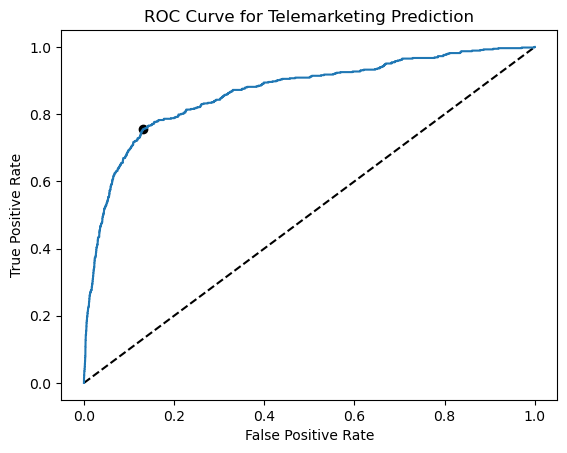

In [456]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telemarketing Prediction')
plt.show()

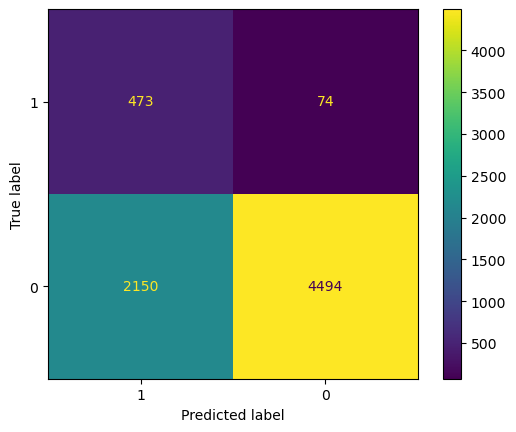

In [458]:
threshold = 0.778605
y_pred_probs = (logregcv.predict_proba(X_test)[:, 1] >= 0.778605).astype(int)
y_pred = logregcv.predict(X_test)
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

This model is good at catching classes of 1 but not very good at avoding class 0 to be classified as 1. A way to reduce False Positives should be considered.

<font size="4"> Hyper parameter tuning using randomized searchcv

While not absolutely necessary, but to ensure AA I want to demonstrate as much as possible in the notebook.

In [168]:
X2 = df.drop("y",axis=1).values
y2 = df["y"].values

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.2,stratify=y,random_state=1)

logreg2 = LogisticRegression( max_iter=300, random_state=1)

params = {#"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

logregcv2 = RandomizedSearchCV(logreg2, params, cv=kf,scoring=["recall","roc_auc"],refit="recall")

logregcv2.fit(X_train2, y_train2)

print("Tuned Logistic Regression Parameters: {}".format(logregcv2.best_params_))
print("Tuned Logistic Regression Best Recall Score: {}".format(logregcv2.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.02050612244897959, 'class_weight': 'balanced', 'C': 0.3020408163265306}
Tuned Logistic Regression Best Recall Score: 0.8117045414882357


Best Threshold=0.574623, G-Mean=0.812


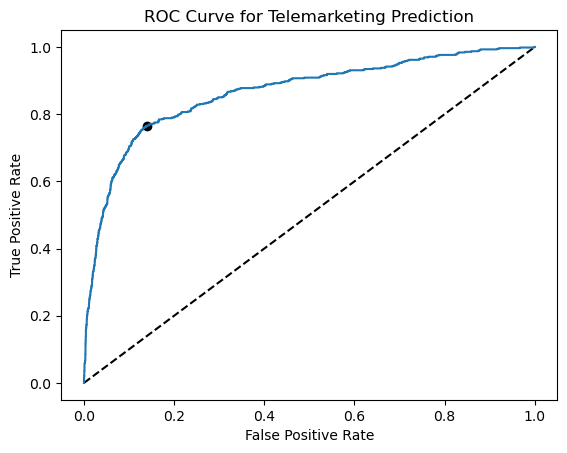

In [169]:
y_pred_probs2 = logregcv2.predict_proba(X_test2)[:, 1]
y_pred2 = logregcv2.predict(X_test2)

fpr, tpr, thresholds = roc_curve(y_test2, y_pred_probs2)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telemarketing Prediction')
plt.show()

In [171]:
threshold = 0.574623
y_pred_new_threshold2 = (logregcv2.predict_proba(X_test2)[:,1]>=0.574623).astype(int)
print(recall_score(y_test2,y_pred_new_threshold2))
print(classification_report(y_test2, y_pred_new_threshold2))

0.7641681901279708
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      6644
           1       0.31      0.76      0.44       547

    accuracy                           0.85      7191
   macro avg       0.64      0.81      0.68      7191
weighted avg       0.93      0.85      0.88      7191



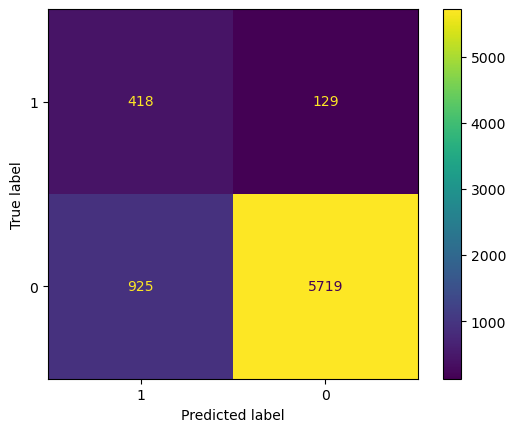

In [172]:
cm = confusion_matrix(y_test2,y_pred_new_threshold2,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

This is a good model most of class 1 are captured while not so many false positives(percentagewise not quantitywise) exist.

### 4.3 Random Forest Classifier (Optimal Model Is Here) <a class="anchor" id="4.3"></a>

In [163]:
n_estimators=[100,250,500,600,750]
#max_depths
max_features=["sqrt","log2","auto"]
min_samples_leaf=[2,8,10,15,30,45]
class_weights= [{1:3,0:0.1},{1:1,0:0.1}]

In [164]:
param_grid={"n_estimators":n_estimators,"max_features":max_features,"min_samples_leaf":min_samples_leaf,"class_weight":class_weights}

In [165]:
rfr=RandomForestClassifier(random_state=1)

In [166]:
rfrCV = GridSearchCV(rfr,param_grid,cv=kf,scoring='recall',n_jobs=-1)

In [167]:
rfrCV.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 3}, {0: 0.1, 1: 1}],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [2, 8, 10, 15, 30, 45],
                         'n_estimators': [100, 250, 500, 600, 750]},
             scoring='recall')

In [168]:
print(rfrCV.best_params_)

{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 45, 'n_estimators': 750}


backup incase kernel is reset <br>
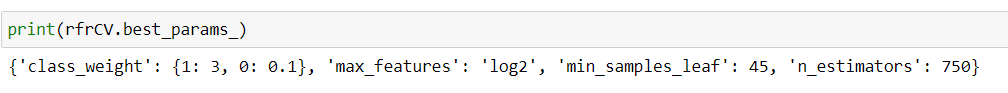

In [193]:
joblib.dump(rfrCV, 'rfrCV_obj.pkl')

['rfrCV_obj.pkl']

In [194]:
joblib_rfrCV = joblib.load("rfrCV_obj.pkl")

In [195]:
print(joblib_rfrCV.best_params_)

{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 45, 'n_estimators': 750}


In [169]:
y_pred=rfrCV.predict(X_test)
print(recall_score(y_test,y_pred))
print(rfrCV.best_params_)
print(classification_report(y_test, y_pred))

0.8464351005484461
{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 45, 'n_estimators': 750}
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      6644
           1       0.23      0.85      0.36       547

    accuracy                           0.77      7191
   macro avg       0.61      0.81      0.61      7191
weighted avg       0.93      0.77      0.82      7191



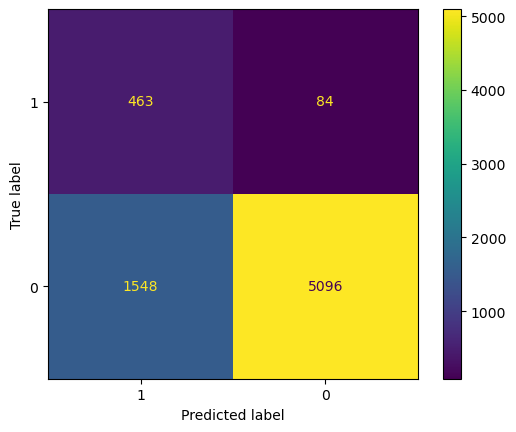

In [205]:
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

**This model corretly predicts %85 of the people in the test set who would subscribe to a term deposit!**

Sadly only %30 of the people who are predicted as 1 are actioally 1. This is still a great improvement but model can be improved.

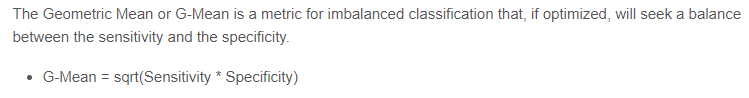

In [182]:
y_pred_probs = rfrCV.predict_proba(X_test)[:, 1]
y_pred = rfrCV.predict(X_test)

Best Threshold=0.087339, Recall=1.000
Best Threshold=0.646796, G-Mean=0.831


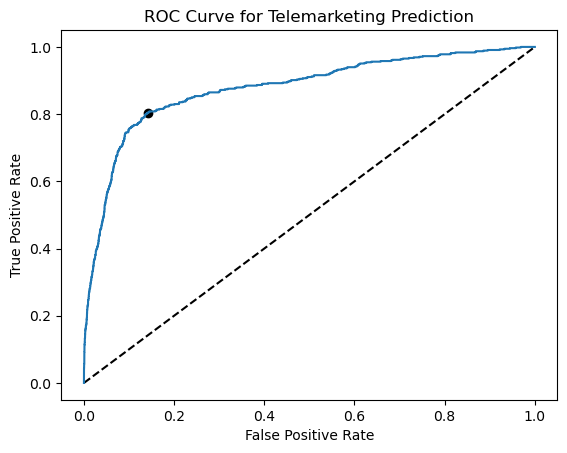

In [186]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

recalls = tpr
ix_recall = np.argmax(recalls)
print('Best Threshold=%f, Recall=%.3f' % (thresholds[ix_recall], recalls[ix_recall]))


gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telemarketing Prediction')
plt.show()

In [173]:
Audio(sound_file, autoplay=True)

In [187]:
thresholds

array([1.9887314 , 0.9887314 , 0.98501521, 0.9849335 , 0.98461587,
       0.98448029, 0.98402943, 0.98396985, 0.98359742, 0.98346161,
       0.98152161, 0.9815205 , 0.98146408, 0.98138646, 0.98080102,
       0.9807733 , 0.97994043, 0.97989545, 0.97985164, 0.97973057,
       0.97954298, 0.97952124, 0.97929581, 0.9791013 , 0.97841285,
       0.97792086, 0.97754945, 0.97731988, 0.97729462, 0.97692509,
       0.97676066, 0.97672287, 0.97560422, 0.97556787, 0.97544845,
       0.97495541, 0.97437542, 0.97195459, 0.97129731, 0.9707252 ,
       0.97002509, 0.97001338, 0.96986376, 0.9684624 , 0.96837426,
       0.96809157, 0.96787069, 0.96745382, 0.96708311, 0.9670426 ,
       0.96600798, 0.96542669, 0.96523691, 0.96492543, 0.96485504,
       0.96422432, 0.96411439, 0.963643  , 0.96354308, 0.96346513,
       0.96184927, 0.96166189, 0.96116333, 0.96101097, 0.96059917,
       0.95980789, 0.95913919, 0.95878262, 0.9586764 , 0.9572992 ,
       0.95689679, 0.95667011, 0.95644816, 0.95563831, 0.95457

In [188]:
threshold = 0.08733887

predicted_proba = rfrCV.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

print(recall_score(y_test,predicted))

0.9981718464351006


After this lets get new scores with the optimal recall for class 1

<font size="4"> **Note: this is just for demonstration reasons I know this will not produce desirable results but I want to show the trade off when increasing recall for class 1**

In [196]:
threshold = 0.08733887
y_pred_new_threshold = (rfrCV.predict_proba(X_test)[:,1]>=0.08733887).astype(int)
#y_pred = rfrCV.predict(X_test)
print(recall_score(y_test,y_pred_new_threshold))
print(classification_report(y_test, y_pred_new_threshold))

0.9981718464351006
              precision    recall  f1-score   support

           0       1.00      0.03      0.06      6644
           1       0.08      1.00      0.15       547

    accuracy                           0.10      7191
   macro avg       0.54      0.51      0.10      7191
weighted avg       0.93      0.10      0.07      7191



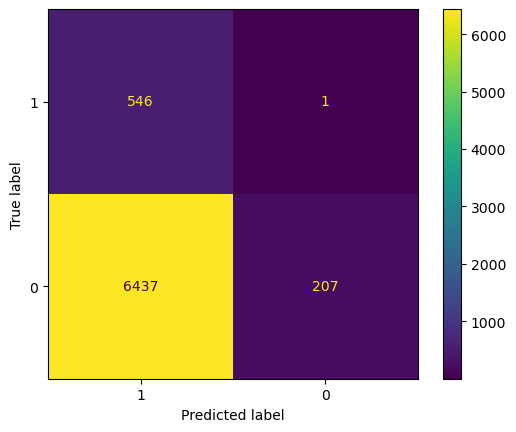

In [208]:
cm = confusion_matrix(y_test,y_pred_new_threshold,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

From here it can be seen that to achieve a good result It could be a good idea to use more metrics during training. But geometric mean can also be usefull.

Adding ROC metric as a secondary metric can overcome the problem above for the second solution although the initial solution is sufficently good.

In [209]:
threshold = 0.64679572
y_pred_new_threshold = (rfrCV.predict_proba(X_test)[:,1]>=0.64679572).astype(int)
print(recall_score(y_test,y_pred_new_threshold))
print(classification_report(y_test, y_pred_new_threshold))

0.8043875685557587
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      6644
           1       0.32      0.80      0.46       547

    accuracy                           0.85      7191
   macro avg       0.65      0.83      0.69      7191
weighted avg       0.93      0.85      0.88      7191



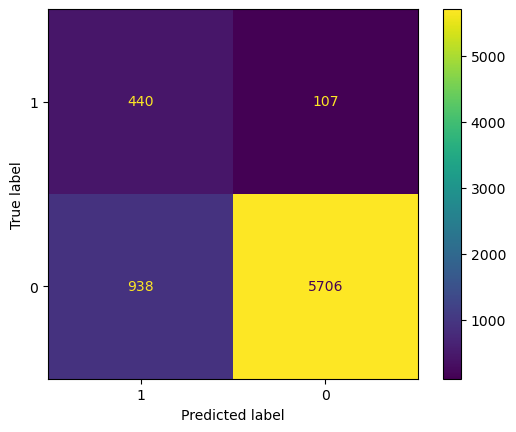

In [210]:
cm = confusion_matrix(y_test,y_pred_new_threshold,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

<font size="4"> **Thanks to geometric mean I know have a more desirable problem. Recall is slightly reduced but the number of false positives have reduced to around 2/3 of its size**

**This model manages to correctly capture %80.4 of the people who would subscribe while eliminating %85.8 of the people who wont**

Backup in case kernel is reset <br>
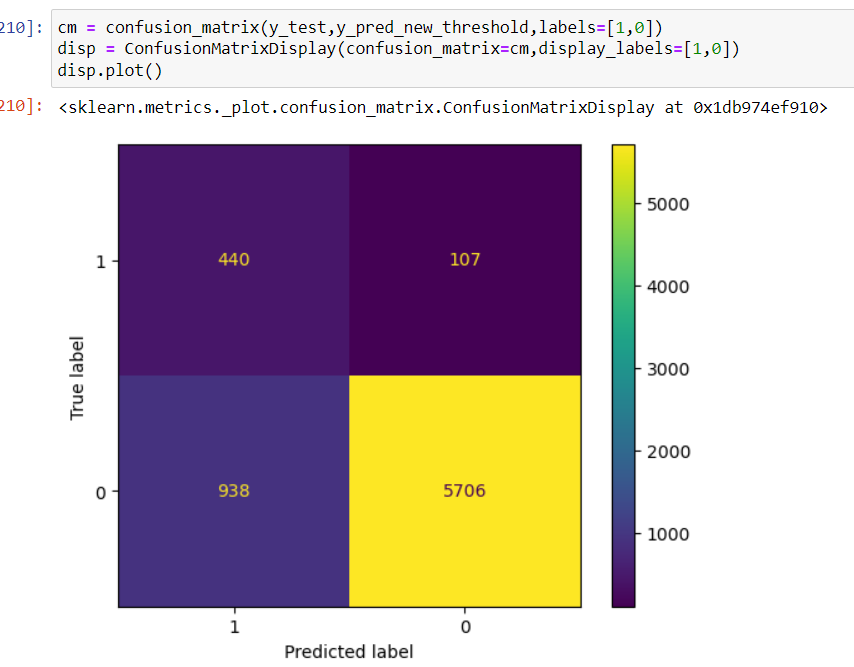

**Using Multiple Metrics For Scoring**

In [215]:
n_estimators=[750,850,1000]
min_samples_leaf=[45,55,65]

In [216]:
param_grid={"n_estimators":n_estimators,"min_samples_leaf":min_samples_leaf,"max_features":["log2"],"class_weight":[{1: 3, 0: 0.1}]}

In [217]:
rfr2 = RandomForestClassifier(random_state=1)

In [218]:
rfrCV2 = GridSearchCV(rfr2,param_grid,cv=kf,n_jobs=-1,scoring=["recall","roc_auc"],refit="recall")

In [219]:
rfrCV2.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 3}],
                         'max_features': ['log2'],
                         'min_samples_leaf': [45, 55, 65],
                         'n_estimators': [750, 850, 1000]},
             refit='recall', scoring=['recall', 'roc_auc'])

In [220]:
print(rfrCV2.best_params_)

{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 65, 'n_estimators': 750}


In [221]:
joblib.dump(rfrCV2, 'rfrCV2_obj.pkl')

['rfrCV2_obj.pkl']

In [222]:
joblib_rfrCV2 = joblib.load("rfrCV2_obj.pkl")

In [223]:
print(joblib_rfrCV2.best_params_)

{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 65, 'n_estimators': 750}


In [224]:
y_pred = rfrCV2.predict(X_test)
print(recall_score(y_test,y_pred))
print(rfrCV2.best_params_)
print(classification_report(y_test, y_pred))

0.8519195612431444
{'class_weight': {1: 3, 0: 0.1}, 'max_features': 'log2', 'min_samples_leaf': 65, 'n_estimators': 750}
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      6644
           1       0.22      0.85      0.34       547

    accuracy                           0.75      7191
   macro avg       0.60      0.80      0.60      7191
weighted avg       0.93      0.75      0.81      7191



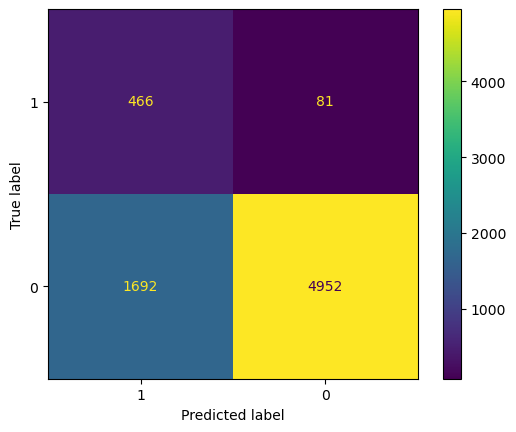

In [225]:
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

**This model manages to correctly capture %85.2 of the people who would subscribe while eliminating %74.5 of the people who wont**

<font size ="4"> **I have chosen this model(the above model) as the optimal model**

In [288]:
joblib_rfrCV2 = joblib.load("rfrCV2_obj.pkl")

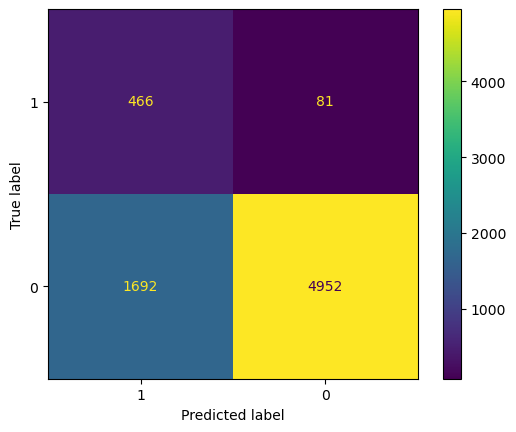

In [289]:
y_pred = joblib_rfrCV2.predict(X_test)
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

In [226]:
y_pred_probs = rfrCV2.predict_proba(X_test)[:, 1]
y_pred = rfrCV2.predict(X_test)

Best Threshold=0.107924, Recall=1.000
Best Threshold=0.696008, G-Mean=0.824


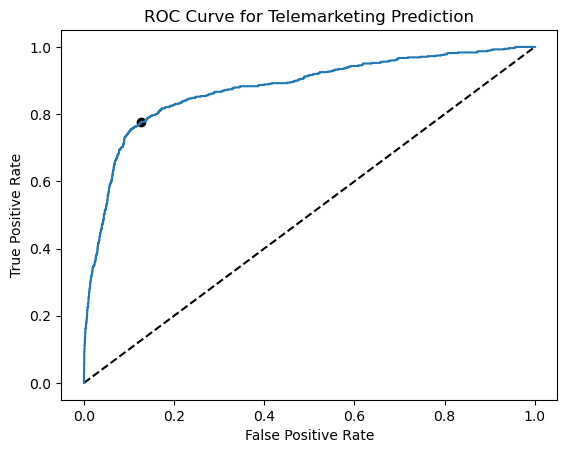

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

recalls = tpr
ix_recall = np.argmax(recalls)
print('Best Threshold=%f, Recall=%.3f' % (thresholds[ix_recall], recalls[ix_recall]))


gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telemarketing Prediction')
plt.show()

In [229]:
threshold = 0.696008
y_pred_new_threshold = (rfrCV2.predict_proba(X_test)[:,1]>=0.696008).astype(int)
print(recall_score(y_test,y_pred_new_threshold))
print(classification_report(y_test, y_pred_new_threshold))

0.7769652650822669
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      6644
           1       0.34      0.78      0.47       547

    accuracy                           0.87      7191
   macro avg       0.66      0.83      0.70      7191
weighted avg       0.93      0.87      0.89      7191



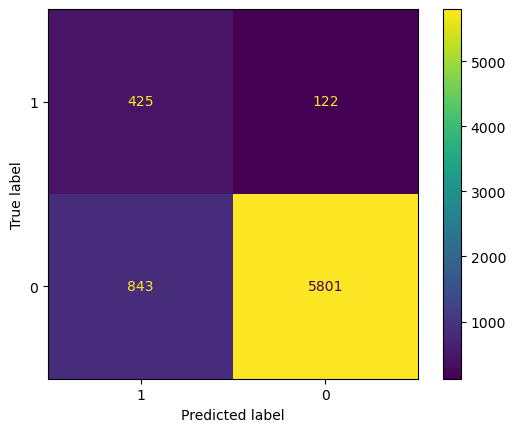

In [230]:
cm = confusion_matrix(y_test,y_pred_new_threshold,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

In [228]:
Audio(sound_file, autoplay=True)

**Finding highest TPR value if elimination of people who wont subscribe can be reduced to at most %70 (or above)**

In [286]:
adj_ix = np.argmax(tpr[np.where(fpr < 0.3)])
print('Best Threshold=%f, Adj-G-Mean=%.3f' % (thresholds[adj_ix], adjusted_gmeans[adj_ix]))

Best Threshold=0.442432, Adj-G-Mean=1.568


0.8647166361974405
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      6644
           1       0.20      0.86      0.32       547

    accuracy                           0.72      7191
   macro avg       0.59      0.79      0.57      7191
weighted avg       0.92      0.72      0.79      7191



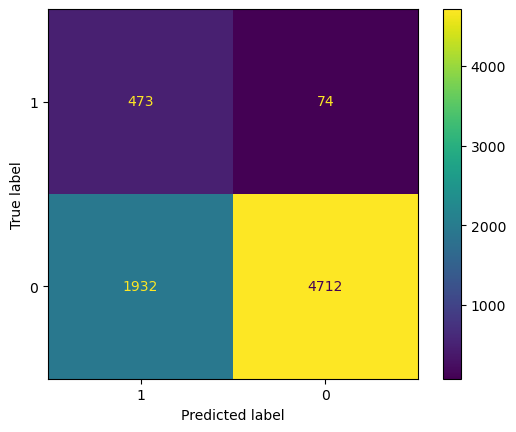

In [287]:
threshold = 0.442432
y_pred_new_threshold = (rfrCV2.predict_proba(X_test)[:,1]>=threshold).astype(int)
print(recall_score(y_test,y_pred_new_threshold))
print(classification_report(y_test, y_pred_new_threshold))
cm = confusion_matrix(y_test,y_pred_new_threshold,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

Improvement to %86 wasnt worth it in my opinion

### 4.4 Decision Tree (Used On Streamlit App) <a class="anchor" id="4.4"></a>

In [192]:
criterions = ["gini", "entropy"]
#max_depths
max_features=["sqrt","log2","auto"]
min_samples_leafs=[1,2,8,10,15,30,45]
min_samples_splits = [2,5]
class_weights= [{1:3,0:0.1},{1:1,0:0.1}]

In [193]:
param_grid={"criterion":criterions,
            "max_features":max_features,
            "min_samples_leaf":min_samples_leafs,
            "min_samples_split":min_samples_splits,
            "class_weight":class_weights}

In [194]:
df_tree

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [195]:
df_tree["y"] = le.fit_transform(df_tree["y"])
df_tree["y"] = df_tree["y"].astype("int") #sckitlearn expects str or int labels

In [197]:
for col in df_tree.columns:
    if df_tree[col].dtype == "object" or df_tree[col].dtype == "category":
        df_tree[col] = le.fit_transform(df_tree[col])

In [198]:
X4 = df_tree.drop("y",axis=1).values
y4 = df_tree["y"].values

In [199]:
X_train4,X_test4,y_train4,y_test4 = train_test_split(X4,y4,test_size=0.2,stratify=y4,random_state=1)

In [200]:
dct = DecisionTreeClassifier(random_state=1)

In [201]:
dctCV = GridSearchCV(dct,param_grid,cv=kf,scoring='recall',n_jobs=-1)

In [202]:
dctCV.fit(X_train4,y_train4)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 3}, {0: 0.1, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 8, 10, 15, 30, 45],
                         'min_samples_split': [2, 5]},
             scoring='recall')

YENIDEN AYNI MODELI KUR VE BAK

In [208]:
dctCV.best_params_

{'class_weight': {1: 3, 0: 0.1},
 'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 45,
 'min_samples_split': 2}

backup incase kernel is reset <br>
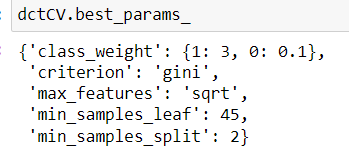

Best Threshold=0.000000, Recall=1.000
Best Threshold=0.795455, G-Mean=0.833


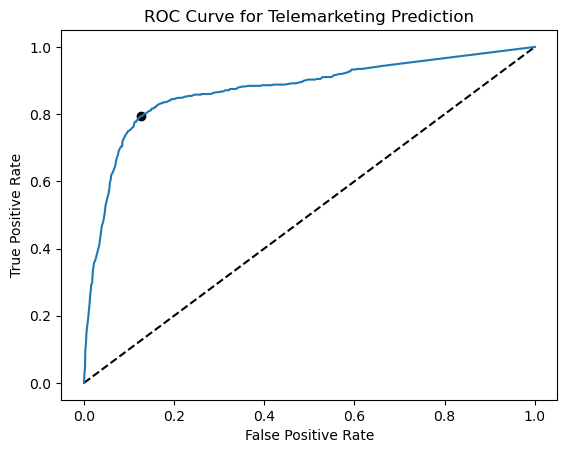

In [204]:
y_pred_probs4 = dctCV.predict_proba(X_test4)[:, 1]
y_pred4 = dctCV.predict(X_test4)

fpr, tpr, thresholds = roc_curve(y_test4, y_pred_probs4)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

recalls = tpr
ix_recall = np.argmax(recalls)
print('Best Threshold=%f, Recall=%.3f' % (thresholds[ix_recall], recalls[ix_recall]))


gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telemarketing Prediction')
plt.show()

0.7906542056074767
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      6481
           1       0.35      0.79      0.48       535

    accuracy                           0.87      7016
   macro avg       0.66      0.83      0.70      7016
weighted avg       0.93      0.87      0.89      7016



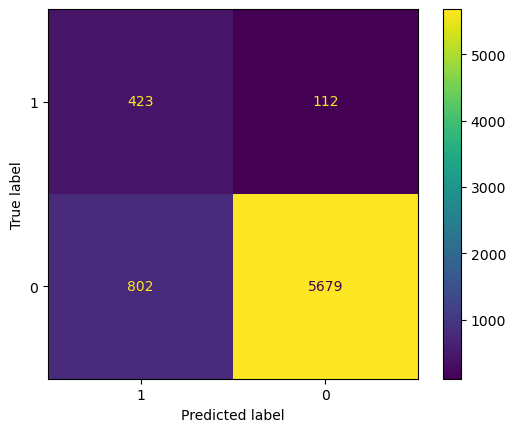

In [206]:
threshold = 0.795455
y_pred_new_threshold4 = (dctCV.predict_proba(X_test4)[:,1]>=threshold).astype(int)
print(recall_score(y_test4,y_pred_new_threshold4))
print(classification_report(y_test4, y_pred_new_threshold4))
cm = confusion_matrix(y_test4,y_pred_new_threshold4,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

0.8149532710280374
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      6481
           1       0.31      0.81      0.45       535

    accuracy                           0.85      7016
   macro avg       0.65      0.83      0.68      7016
weighted avg       0.93      0.85      0.88      7016



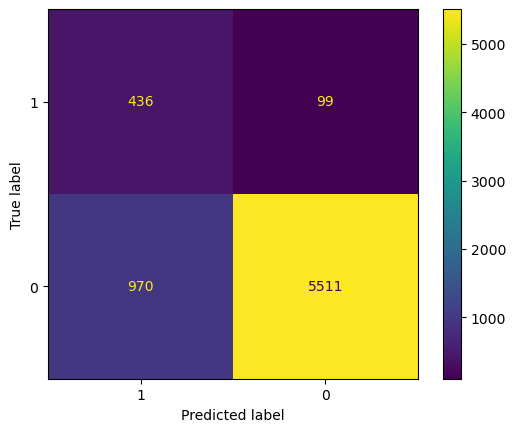

In [211]:
threshold = 0.725455
y_pred_new_threshold4 = (dctCV.predict_proba(X_test4)[:,1]>=threshold).astype(int)
print(recall_score(y_test4,y_pred_new_threshold4))
print(classification_report(y_test4, y_pred_new_threshold4))
cm = confusion_matrix(y_test4,y_pred_new_threshold4,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

The result is a nice model

In [212]:
joblib.dump(dctCV, 'dctCV_obj.pkl')

['dctCV_obj.pkl']

In [213]:
joblib_dctCV = joblib.load("dctCV_obj.pkl")

<font size="4"> **I decided to use this model on streamlit app as it will be much more easier to implement and the results are near my optimal model which was stated above**

<font size="4"> **Streamlit cloud address**

https://cemkocak-ads564-project-app.streamlit.app/

### 4.5 Gradient Boosting Classifier <a class="anchor" id="4.5"></a>

This model was removed as the notebook was becoming too crowded.

### 4.6 XGBoost <a class="anchor" id="4.6"></a>

In [110]:
# To prevent data leakage on the computation that I will do later I am creating dummy train test variables
X_trainD,X_testD,y_trainD,y_testD = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [111]:
# below was also used in loops and resulting decision was to remove dart from consideration because it doest improve performance
# by reducing overfit as described in the documentation this is sometimes the case, however it provides slower computation than
# gbtree
#boosters =["gbtree","dart"]

In [112]:
max_depths=[3, 6, 8]
max_depths

[3, 6, 8]

In [113]:
learning_rates=np.arange(0.2,1,0.2)
learning_rates

array([0.2, 0.4, 0.6, 0.8])

In [114]:
#more checking was done initialy that was removed scale_pos_weights = [1,0.99,0.97,0.90]
scale_pos_weights = [1,0.90]
scale_pos_weights

[1, 0.9]

In [115]:
n_estimators=[100,250,350,500,600,750]
n_estimators

[100, 250, 350, 500, 600, 750]

In [116]:
param_grid={
                                         "max_depth" : max_depths,
                                         "learning_rate" : learning_rates,
                                         "scale_pos_weight" : scale_pos_weights,
                                         "n_estimators" : n_estimators,
                                         }

In [117]:
xgb = XGBClassifier(random_state = 1, objective = "binary:logistic",eval_metric="auc",n_jobs=-1)

In [118]:
xgbCV = GridSearchCV(xgb,param_grid,cv=kf,scoring='recall',n_jobs=-1)

In [119]:
xgbCV.fit(X_trainD,y_trainD)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.2, 0.4, 0.6, 0.8]),
                         'max_depth': [3, 6, 8],
                         'n_estimators': [100, 250, 350, 500, 600, 750],
                         'scale_pos_weight': [1, 0.9]},
             scoring='recall')

In [120]:
print(xgbCV.best_params_)

{'learning_rate': 0.8, 'max_depth': 6, 'n_estimators': 600, 'scale_pos_weight': 1}


backup incase kernel is reset <br>
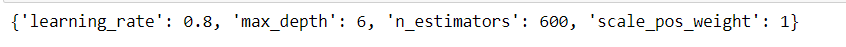

In [121]:
y_pred_probsD = xgbCV.predict_proba(X_testD)[:, 1]
y_predD = xgbCV.predict(X_testD)

score = recall_score(y_testD,y_predD)

In [122]:
score

0.39488117001828155

<font size ="5"> **After this result as well as some others this model was chosen to be abandoned. I am leaving one of the codes below to show I have done various experimentations all of which yielded poor results.**

In [131]:

for max_depthsD in max_depths:
    for learning_ratesD in learning_rates:
        for scale_pos_weightsD in scale_pos_weights:
            for n_estimatorsD in n_estimators:
                xgbD = XGBClassifier(booster = gbtree,
                                         max_depth = max_depthsD,
                                         learning_rate = learning_ratesD,
                                         scale_pos_weight = scale_pos_weightsD,
                                         n_estimators = n_estimatorsD,
                                         random_state = 1, objective = "binary:logistic",eval_metric="auc",n_jobs=-1)
                xgbD.fit(X_trainD,y_trainD)
                y_pred_probsD = xgbD.predict_proba(X_testD)[:, 1]
                y_predD = xgbD.predict(X_testD)

                score = recall_score(y_testD,y_predD)
                fpr, tpr, thresholds = roc_curve(y_testD, y_pred_probsD)
                gmeans = np.sqrt(tpr * (1-fpr))
                ix = np.argmax(gmeans)
                print(boostersD,max_depthsD,score)
                if score > max_score:
                    max_score = score
                    best_params1[0] = max_depthsD
                    best_params1[1] = learning_ratesD
                    best_params1[2] = scale_pos_weightsD
                    best_params1[3] = n_estimatorsD
                if gmeans[ix] > best_threshold[2]:
                    best_threshold[0] = ix
                    best_threshold[1] = thresholds[ix]
                    best_threshold[2] = gmeans[ix]
                    best_params2[0] = max_depthsD
                    best_params2[1] = learning_ratesD
                    best_params2[2] = scale_pos_weightsD
                    best_params2[3] = n_estimatorsD


    print("Checkpoint")

gbtree 3 0.33089579524680074
gbtree 3 0.3491773308957952
gbtree 3 0.3217550274223035
gbtree 3 0.33638025594149906
gbtree 3 0.35283363802559414
gbtree 3 0.36745886654478976
gbtree 3 0.360146252285192
gbtree 3 0.36745886654478976
gbtree 3 0.360146252285192
gbtree 3 0.3711151736745887
gbtree 3 0.3583180987202925
gbtree 3 0.3930530164533821
Checkpoint
gbtree 4 0.32541133455210236
gbtree 4 0.360146252285192
gbtree 4 0.3272394881170018
gbtree 4 0.3546617915904936
gbtree 4 0.376599634369287
gbtree 4 0.3802559414990859
gbtree 4 0.3491773308957952
gbtree 4 0.3656307129798903
gbtree 4 0.37294332723948814
gbtree 4 0.40036563071297987
gbtree 4 0.3619744058500914
gbtree 4 0.3820840950639854
Checkpoint
dart 3 0.33089579524680074
dart 3 0.3491773308957952
dart 3 0.3217550274223035
dart 3 0.33638025594149906
dart 3 0.35283363802559414
dart 3 0.36745886654478976
dart 3 0.360146252285192
dart 3 0.36745886654478976
dart 3 0.360146252285192
dart 3 0.3711151736745887
dart 3 0.3583180987202925
dart 3 0.3930

### 4.7 Imputation To Satisfy Project Requirements <a class="anchor" id="4.7"></a>

**After taking permission in class, I decided to only use pipeline for one of the models**

The pipeline is assuming LabelEncoder's fit_transform method is defined to take three positional arguments:
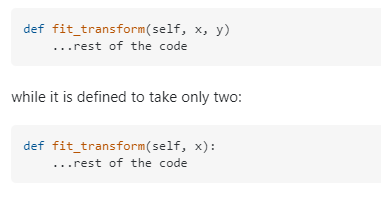
<br>
Because of this I have no choice but to use onehot encoder on pipeline and edit other columns myself.

In [425]:
df_pip["contacted_before"] = np.where(df_pip["pdays"]!= 999, 1, 0)
df_pip.drop(columns=["pdays"],axis=1,inplace=True)
dummies=pd.get_dummies(df_pip[["marital","default","poutcome","job"]])
dummies.drop(["marital_divorced","default_unknown","poutcome_nonexistent","job_unemployed"],axis=1,inplace=True)
df_pip = df_pip.join(dummies)
df_pip.drop(["marital","default","poutcome","job"],axis=1,inplace=True)

In [426]:
num_cols = [df_pip.columns.get_loc(c) for c in df_pip.columns if c in df_pip.select_dtypes(include=["int64","float64"]).columns.tolist()]


In [427]:
cat_cols = [df_pip.columns.get_loc(c) for c in df_pip.columns if c in df_pip.select_dtypes(include=["category"]).columns.tolist()]


In [428]:
df_pip["y"] = le.fit_transform(df_pip["y"])

In [429]:
df_pip.select_dtypes(include=["category"]).columns.tolist()


['housing', 'loan', 'contact']

In [430]:
cat_cols = cat_cols[:-1]

In [431]:
X3 = df_pip.drop("y",axis=1).values
y3 = df_pip["y"].values
X_train3,X_test3,y_train3,y_test3 = train_test_split(X3,y3,test_size=0.2,stratify=y,random_state=1)

In [432]:
param_grid = {"logreg__C":[0.1,1.0,5.0,10.0],
        "logreg__penalty":["l2"]}

In [433]:
preparer1=ColumnTransformer([
    ("preparer1",SimpleImputer(strategy="median"),num_cols)
],remainder="passthrough")
preparer2=ColumnTransformer([
    ("preparer2",MinMaxScaler(),num_cols)
],remainder="passthrough")

preparer3=ColumnTransformer([
    ("preparer3",SimpleImputer(strategy="most_frequent"),cat_cols)
],remainder="passthrough")
preparer4=ColumnTransformer([
    ("preparer4",OneHotEncoder(sparse_output=False, handle_unknown='ignore'),cat_cols) #("preparer4",LabelEncoder(),cat_cols)
],remainder="passthrough")

steps = [("preparer4", preparer4),("preparer1", preparer1),("preparer2", preparer2),("preparer3", preparer3),
         ("logreg", LogisticRegression(solver='lbfgs', max_iter=300))]

pipeline = Pipeline(steps)
cv = GridSearchCV(pipeline,param_grid)
cv.fit(X_train3,y_train3)
y_pred3 = cv.predict(X_test3)

In [437]:
cv.best_params_

{'logreg__C': 0.1, 'logreg__penalty': 'l2'}

cv.predict predicts with best parameters <br>
source: <br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

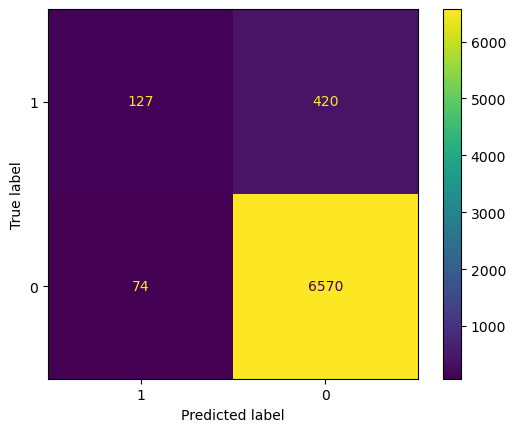

In [435]:
cm = confusion_matrix(y_test3,y_pred3,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

<font size="5"> **I wont try to optimize this bad model because I dont plan on using this model anyway this was only done to satisfy pipeline requirement of the project**

## 5. Conclusion <a class="anchor" id="5"></a>

The optimal model which was chosen as the best performing of the random forest classifier models, correctly captures %85.2 of the people who would subscribe while eliminating %74.5 of the people who wont. This is a great score with a also a high auc roc score. Considering I have chosen to drop duration parameter to have a realistic predictive model, this result shows a very successfull AA deserving project where I have applied both inclass knowledge and various outside class knowledge I have learned.